In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# from fastai.tabular import *
from fastai.text import *

In [3]:
PATH = Path()

In [4]:
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

In [5]:
loss_fn = CrossEntropyFlat()

def f1(preds, targs):
    # metrics must return a rank0 tensor
    return tensor(f1_score(targs.view(-1).detach().cpu(), preds.argmax(-1).view(-1).detach().cpu(), average='macro'))

In [6]:
# train = pd.read_csv(PATH/"train.csv")
# test = pd.read_csv(PATH/"test.csv")

train = pd.read_csv(PATH/"train_clean.csv")   # data-without-drift
test = pd.read_csv(PATH/"test_clean.csv")

# train = pd.read_csv(PATH/"train_detrend.csv") # detrended w/ histogram
# test = pd.read_csv(PATH/"test_detrend.csv")

subm = pd.read_csv(PATH/"sample_submission.csv")

In [7]:
def trn_val_split(rows, percent=0.2):   # randomized non-sequential splits
    "returns trn_idxs, val_idxs"
    indices = np.random.permutation(rows)  # randomly permute rows
    num = int(rows*percent)
    return indices[num:], indices[:num]

In [8]:
class Ion_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx], dtype=torch.float)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x,y

In [9]:
def show_subset(start,end,step,df=train,add_fields=[],title=None):
    plt.figure(figsize=(20,5))
    plt.plot(df.signal[start:end:step], label='signal')
    #if 'open_channels' in df.columns.values: plt.plot(df.open_channels[start:end:step], label='open_channels')
    [plt.plot(df[field][start:end:step], label=field) for field in add_fields]
    #plt.xlabel('Time (*1e4)', size=16)
    plt.ylabel('Signal / Channels Open', size=16);
    title = title if title else f'{start} - {end}  ({end-start}/{step})'
    plt.title(title,size=20)
    if len(add_fields)>0: plt.legend()
    plt.show()

def random_subsets(n=10, length=500, step=10, add_fields=None):
    for k in range(n):
        start = np.random.randint(0, len(train)-length)
        end = start + length
        show_subset(start,end,step,add_fields)

# Data Visualization

IMPORTANT: While the time series appears continuous, the data is from discrete batches of 50 seconds long 10 kHz samples (500,000 rows per batch). In other words, the data from 0.0001 - 50.0000 is a different batch than 50.0001 - 100.0000, and thus discontinuous between 50.0000 and 50.0001

In [ ]:
train.head()

In [ ]:
len(train)

In [ ]:
# imbalanced dataset
c = Counter(train.open_channels); c

c.most_common()

for i,n in c.most_common():
    print(f"{i}: {round(n/5000000, 2)}")

In [ ]:
train.describe()

In [ ]:
# signal stats
print(f"mean: {train.signal.mean()}\nmin: {train.signal.min()}\nmax: {train.signal.max()}")

In [ ]:
# open channel stats
print(f"mean: {train.open_channels.mean()}\nmin: {train.open_channels.min()}\nmax: {train.open_channels.max()}")

In [120]:
step = 10000    # step

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train.signal[0::step])

plt.vlines(range(0,len(train),500000),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(10): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Signal', size=16); 
plt.title(f'Signal - batches / {step}',size=20)
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train.open_channels[0::step])

plt.vlines(range(0,len(train),500000),-1,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(10): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Open Channels', size=16);
plt.title(f'Open Channels - batches / {step}',size=20)
plt.show()

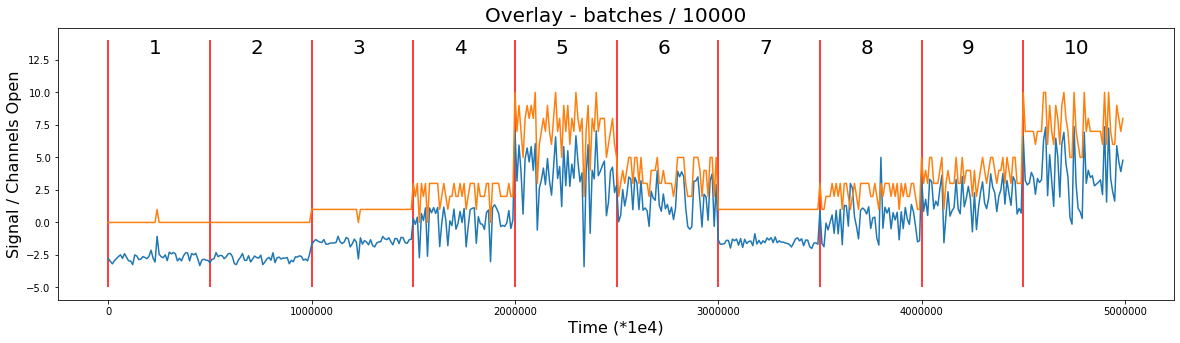

In [121]:
plt.figure(figsize=(20,5))
plt.plot(train.signal[::step])

plt.plot(train.open_channels[::step])

plt.vlines(range(0,len(train),500000),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(10): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Signal / Channels Open', size=16); 
plt.title(f'Overlay - batches / {step}',size=20)
plt.show()

## zoom in

In [ ]:
for beg,end in zip(steps[0::1],steps[1::1]):
    #show_subset(beg,end-1,1000)
    group = train[beg:end].signal
    print(f"mean: {round(group.mean(), 3)}, std: {round(group.std(), 3)}, \
Q01: {round(group.quantile(.01), 3)}, Q99: {round(group.quantile(.99),3)}\n")

In [ ]:
show_subsets(n=2, length=2000000, step=10000)

### histogram per batch

In [60]:
def hist_per_batch(batches, df):
    fig,axes = plt.subplots(len(batches)-1,1,figsize=(15,15))
    for i,(beg,end) in enumerate(zip(batches[0::],batches[1::])):
        g = df[beg:end].signal
        axes[i].hist(g, bins=50, range=(-5,10)); None

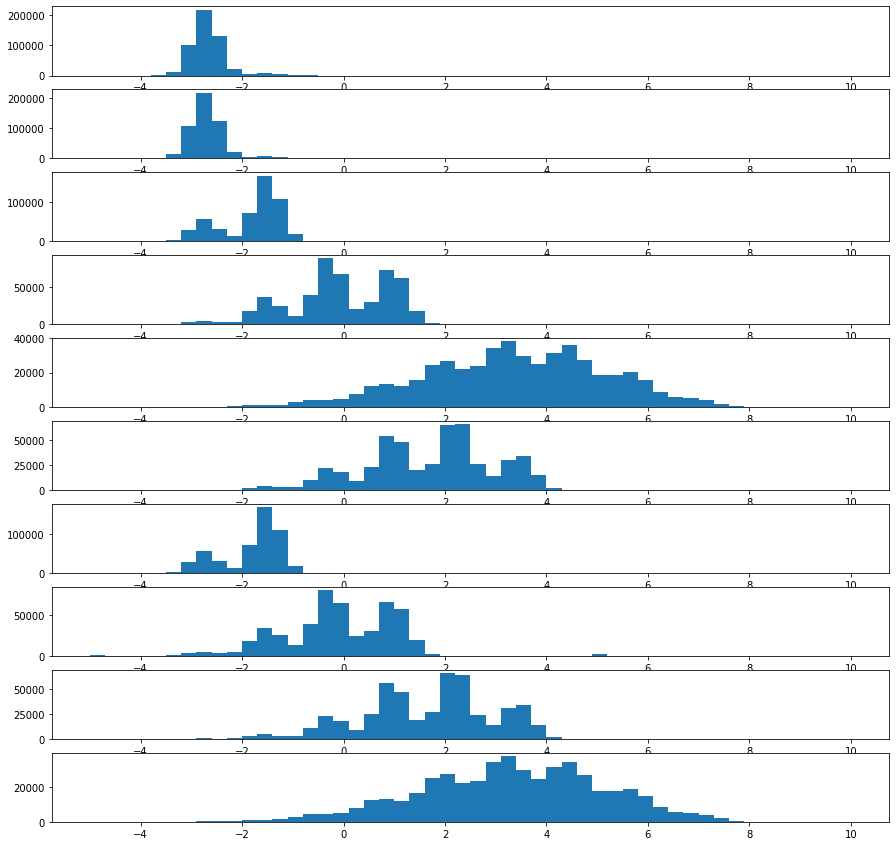

In [56]:
hist_per_batch(batches, train)

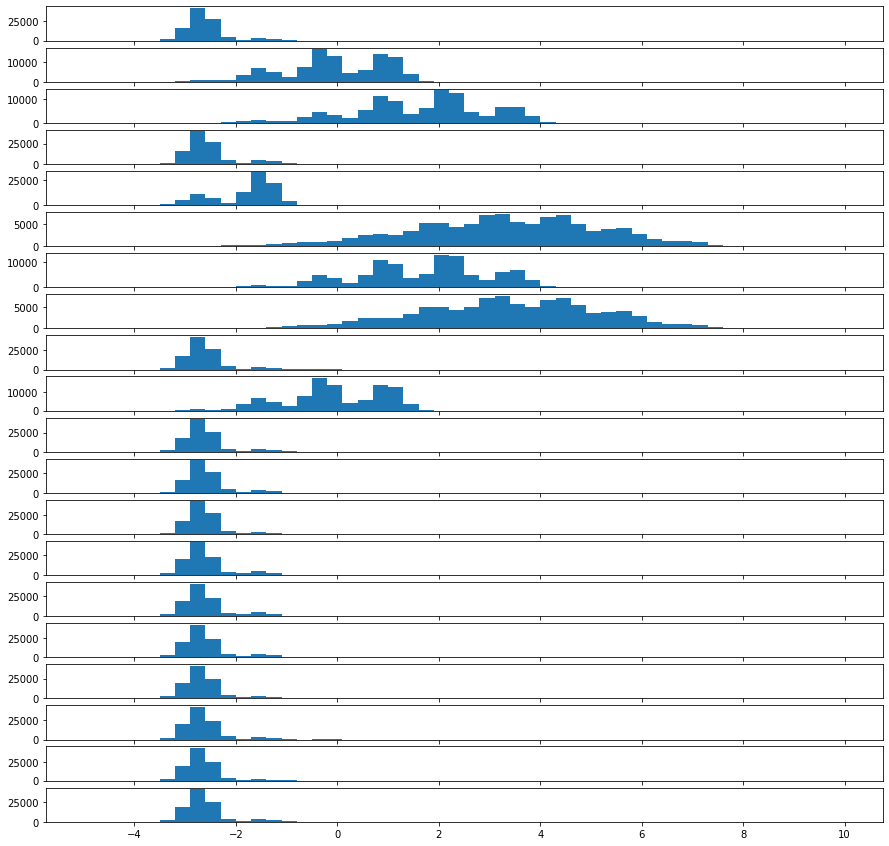

In [61]:
hist_per_batch(test_batches, test)

### display each batch

In [37]:
batches = list(range(0,5000001,500000))
test_batches = list(range(0,2000001,100000))

In [222]:
# signal per batch
for i,(beg,end) in enumerate(zip(batches[0::],batches[1::])):
    g = train[beg:end].signal
    f = lambda x: round(x,3)  # rounding function
    print(f"batch {i+1} - mean: {f(g.mean())}, std: {f(g.std())}, Q01: {f(g.quantile(.01))}, Q99: {f(g.quantile(.99))}")

batch 1 - mean: -2.681, std: 0.33, Q01: -3.296, Q99: -1.365
batch 2 - mean: -2.683, std: 0.346, Q01: -3.308, Q99: -1.328
batch 3 - mean: -1.813, std: 0.59, Q01: -3.171, Q99: -0.953
batch 4 - mean: -0.093, std: 1.003, Q01: -2.792, Q99: 1.478
batch 5 - mean: 3.358, std: 1.818, Q01: -1.108, Q99: 7.125
batch 6 - mean: 1.681, std: 1.279, Q01: -1.614, Q99: 3.906
batch 7 - mean: -1.804, std: 0.586, Q01: -3.166, Q99: -0.952
batch 8 - mean: -0.108, std: 1.17, Q01: -3.133, Q99: 1.9
batch 9 - mean: 1.659, std: 1.284, Q01: -1.634, Q99: 3.894
batch 10 - mean: 3.311, std: 1.819, Q01: -1.124, Q99: 7.113


In [211]:
# channels per batch
for i,(beg,end) in enumerate(zip(batches[0::],batches[1::])):
    c = train[beg:end].open_channels
    print(f'batch {i+1} - min: {c.min()}, max: {c.max()}, mean: {c.mean()}')

batch 1 - min: 0, max: 1, mean: 0.031732
batch 2 - min: 0, max: 1, mean: 0.038676
batch 3 - min: 0, max: 1, mean: 0.747992
batch 4 - min: 0, max: 3, mean: 2.147846
batch 5 - min: 0, max: 10, mean: 7.147186
batch 6 - min: 0, max: 5, mean: 3.576684
batch 7 - min: 0, max: 1, mean: 0.75361
batch 8 - min: 0, max: 3, mean: 2.135186
batch 9 - min: 0, max: 5, mean: 3.570304
batch 10 - min: 1, max: 10, mean: 7.111216


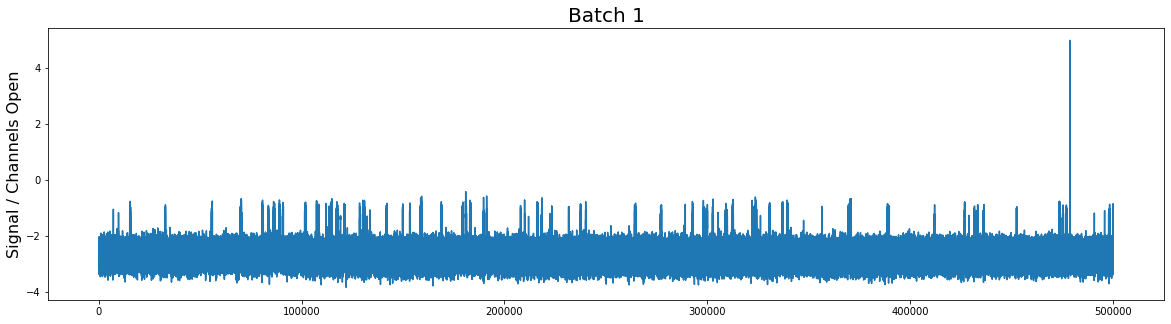

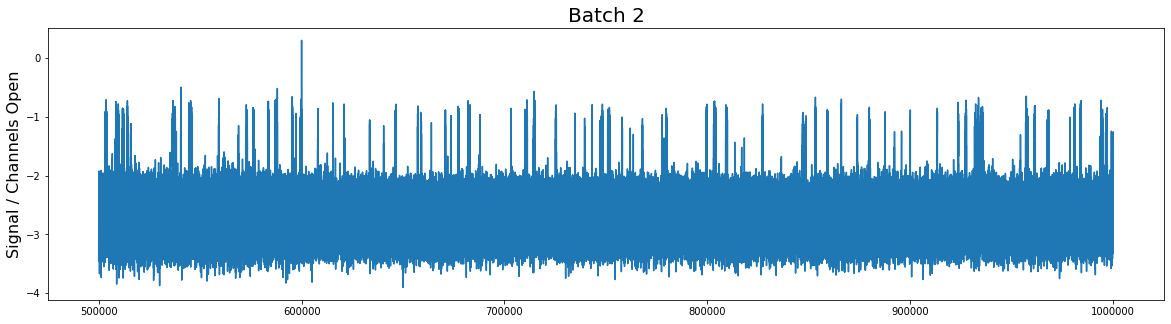

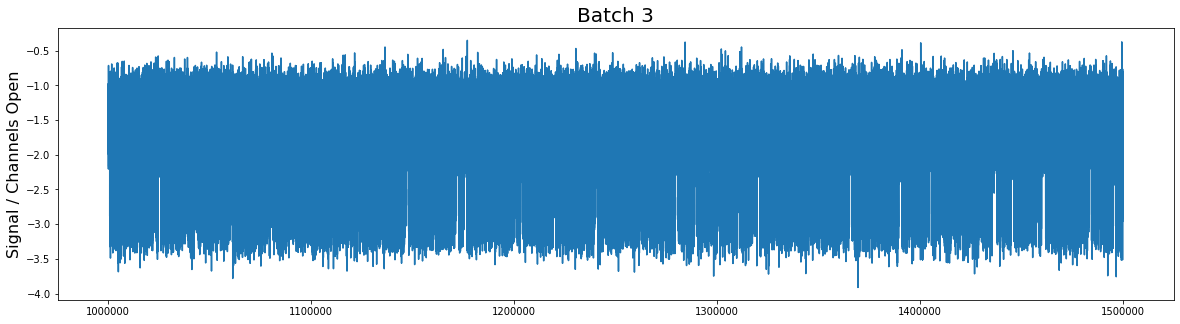

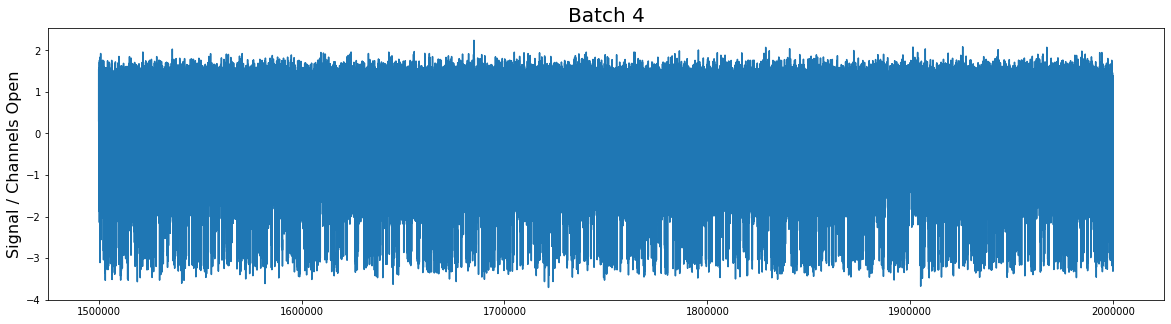

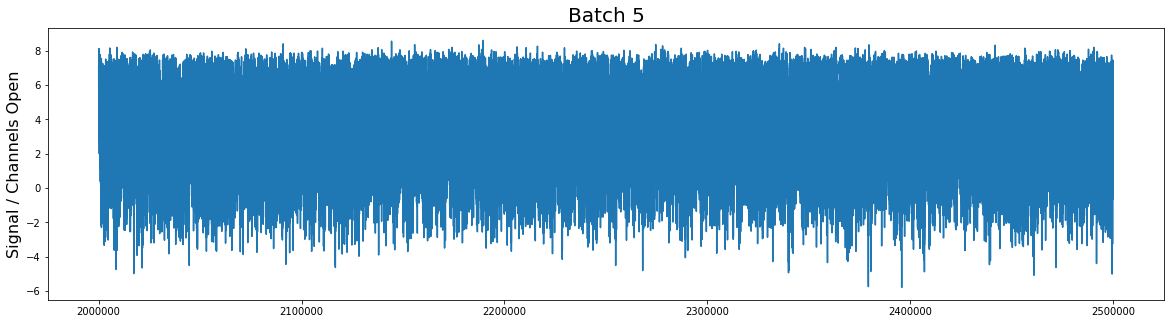

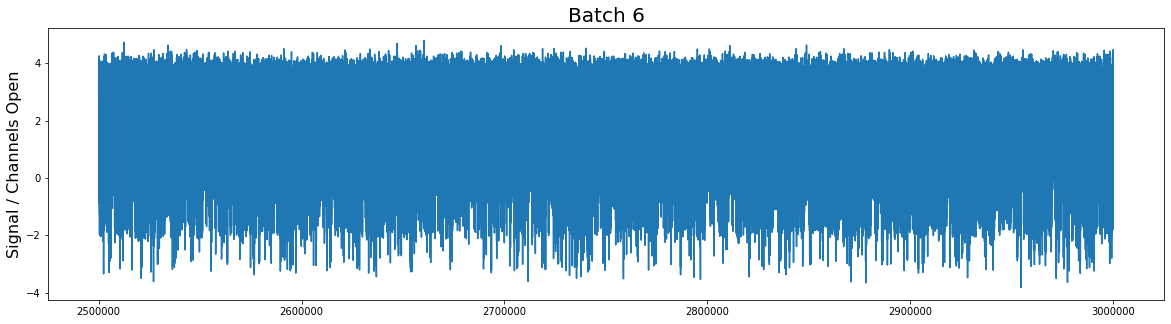

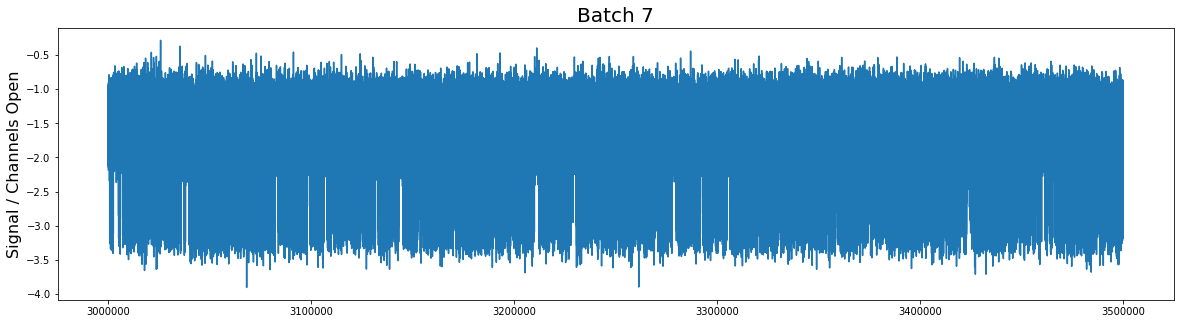

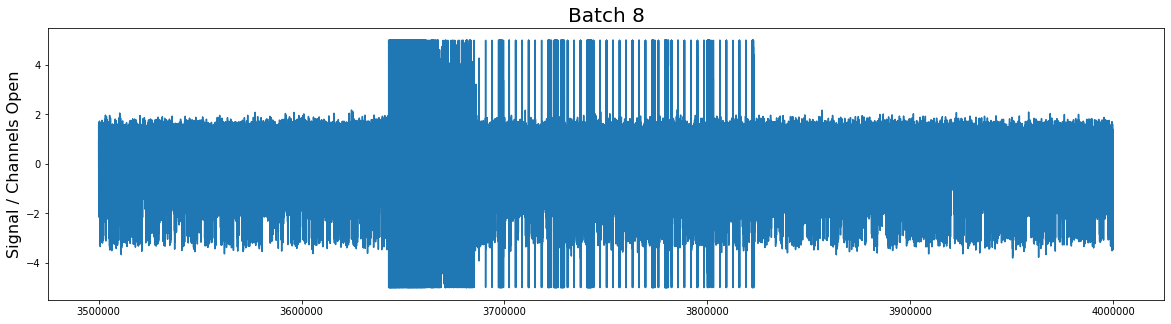

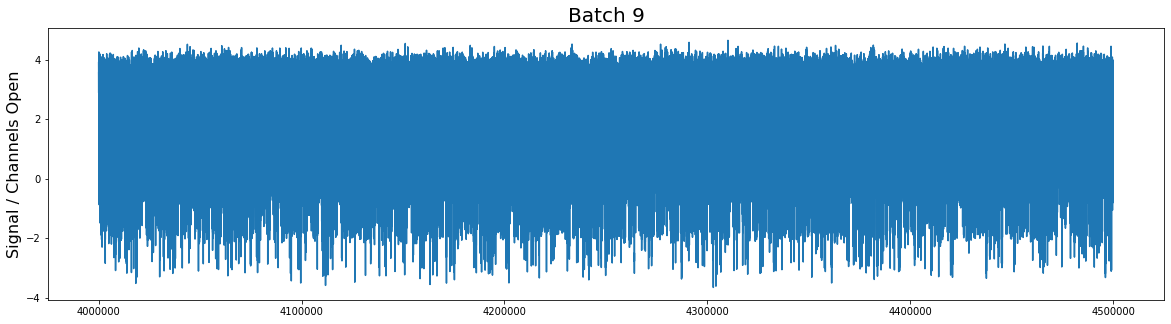

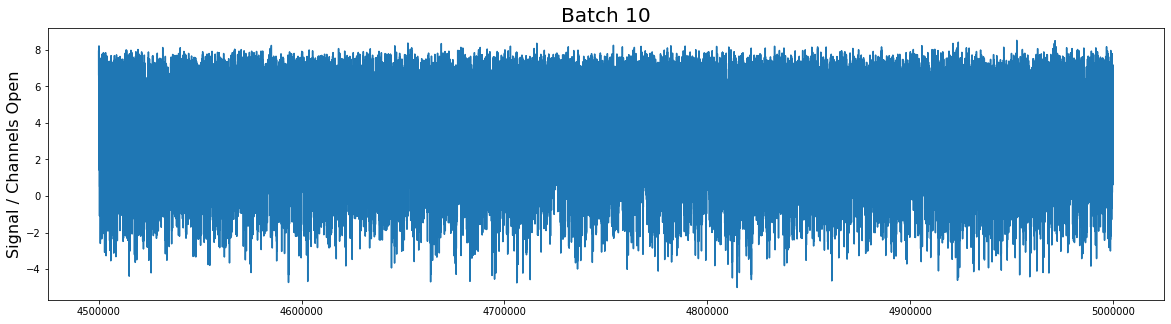

In [356]:
for i,(beg,end) in enumerate(zip(batches[0::],batches[1::])):
    show_subset(beg,end-1,step=1,title=f'Batch {i+1}')

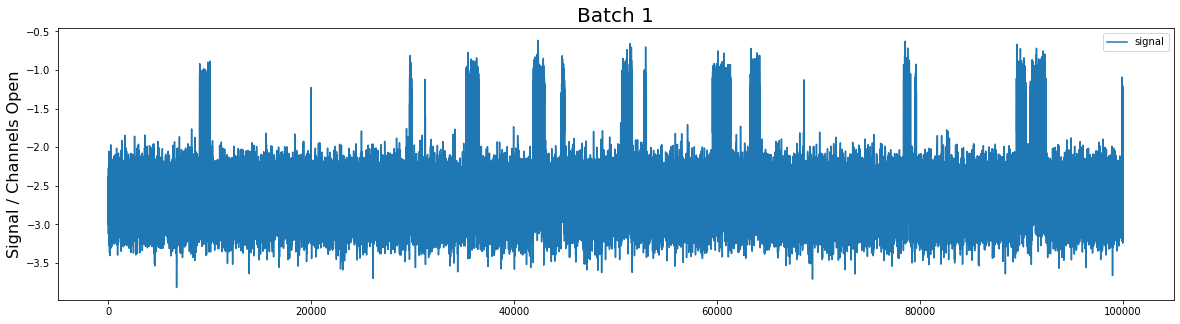

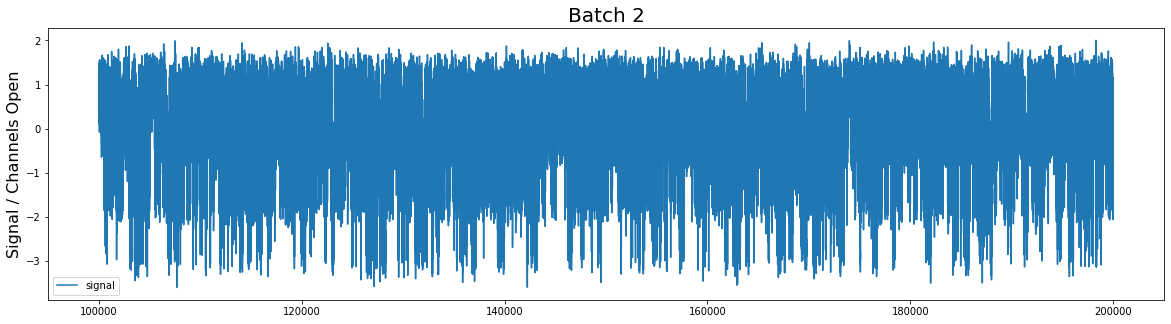

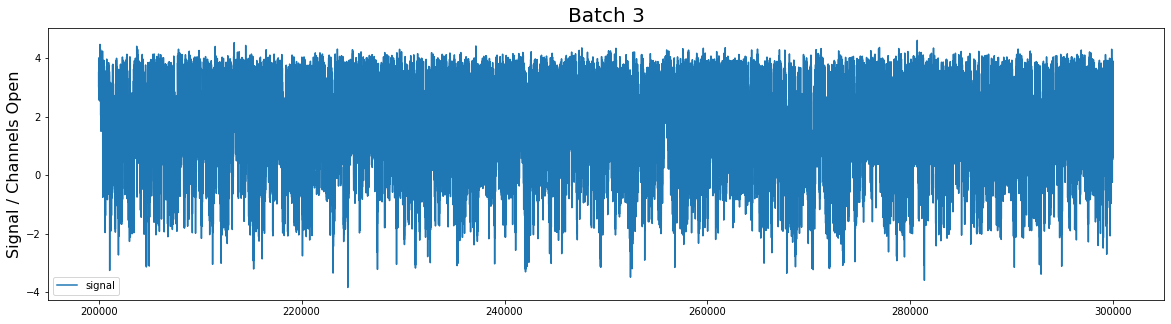

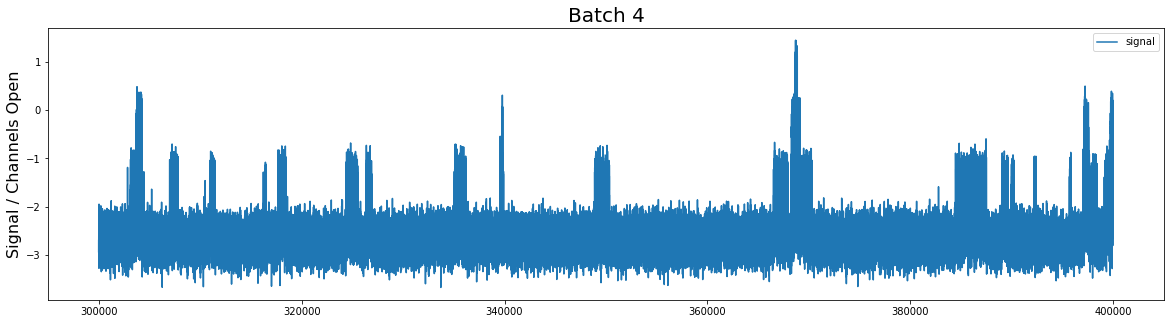

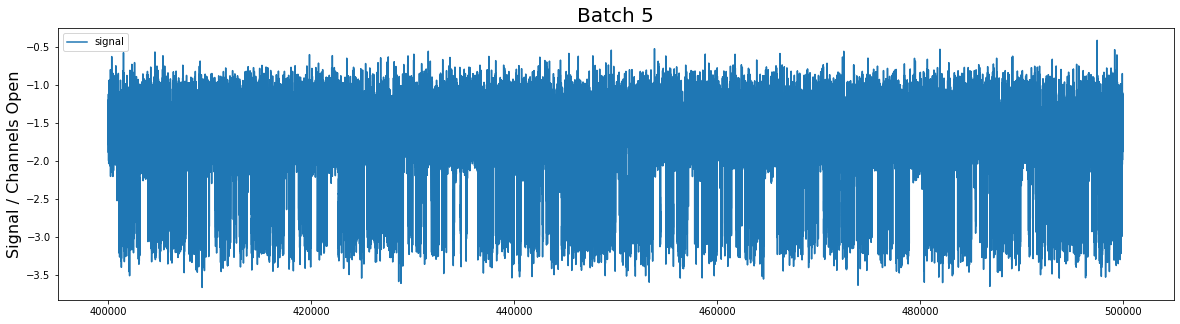

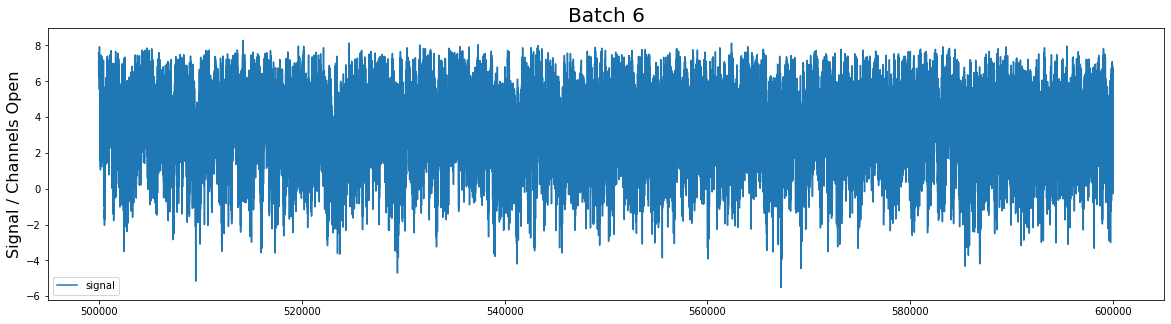

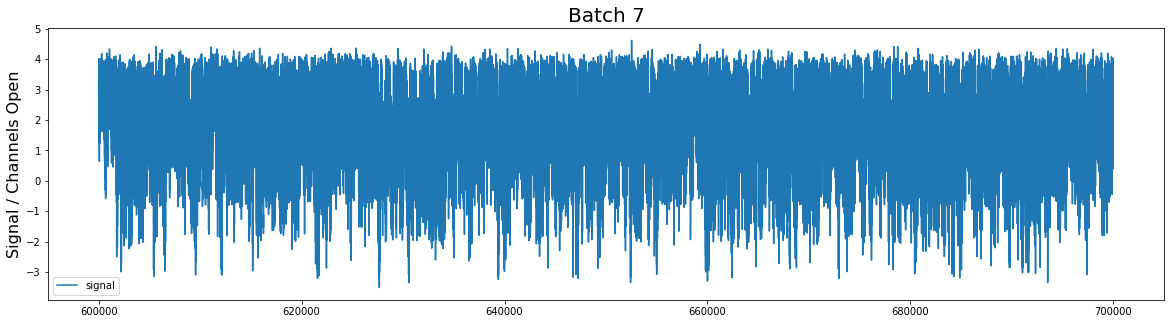

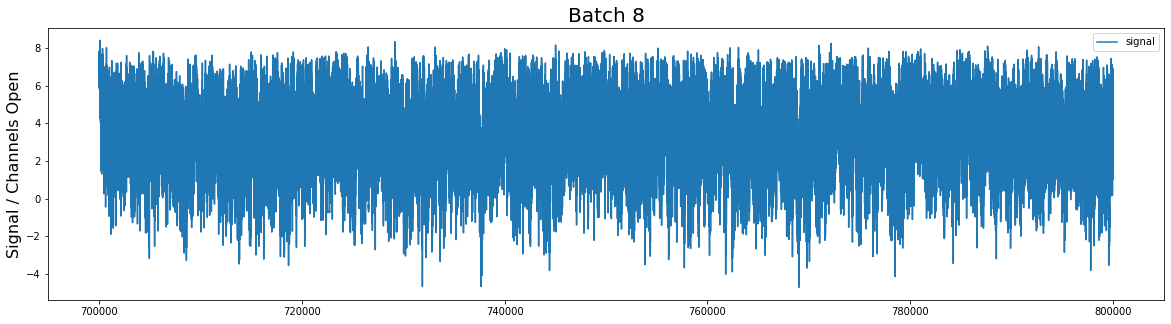

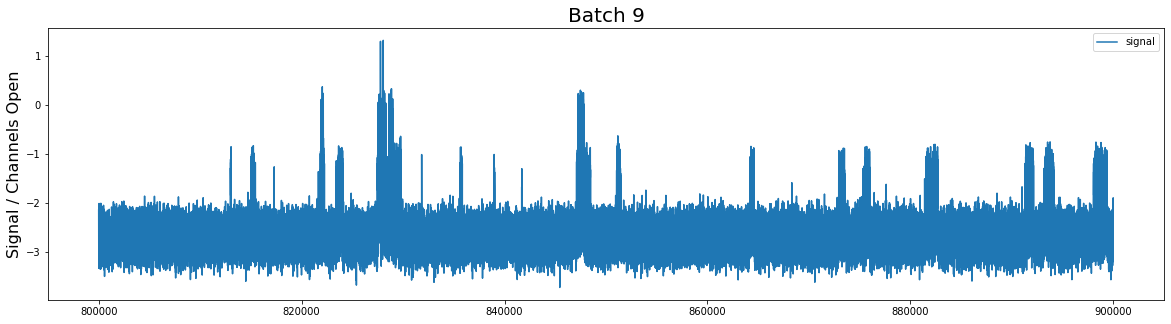

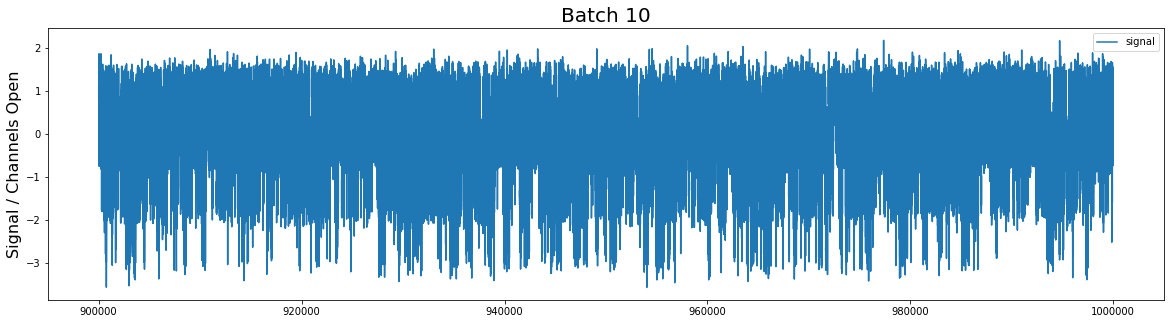

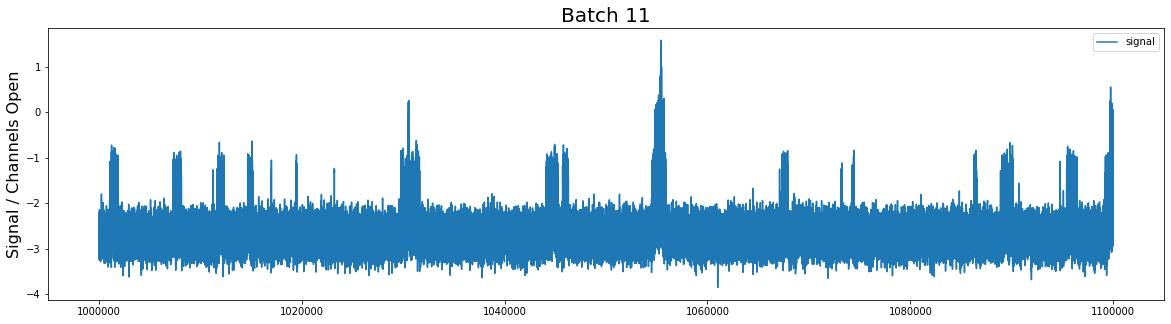

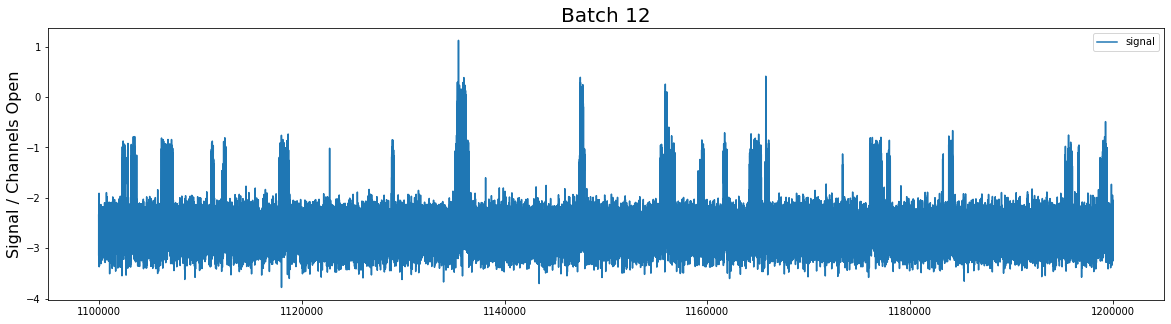

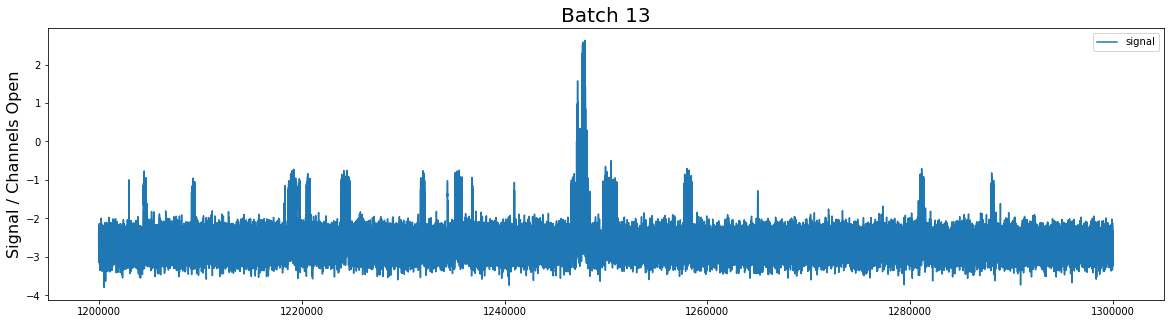

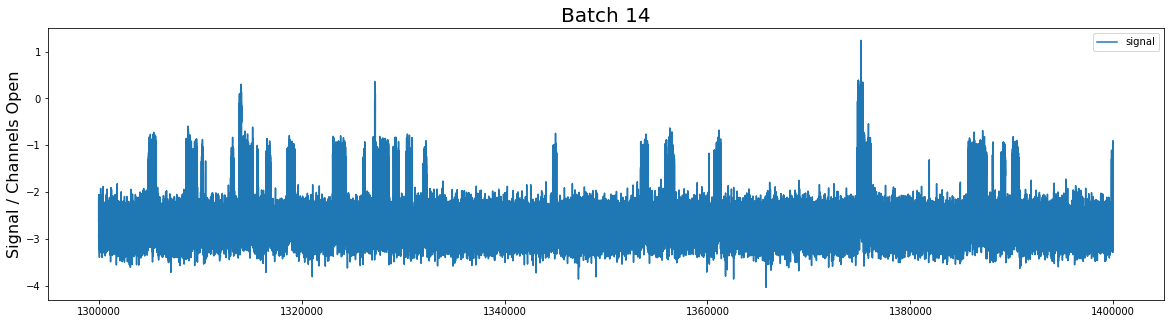

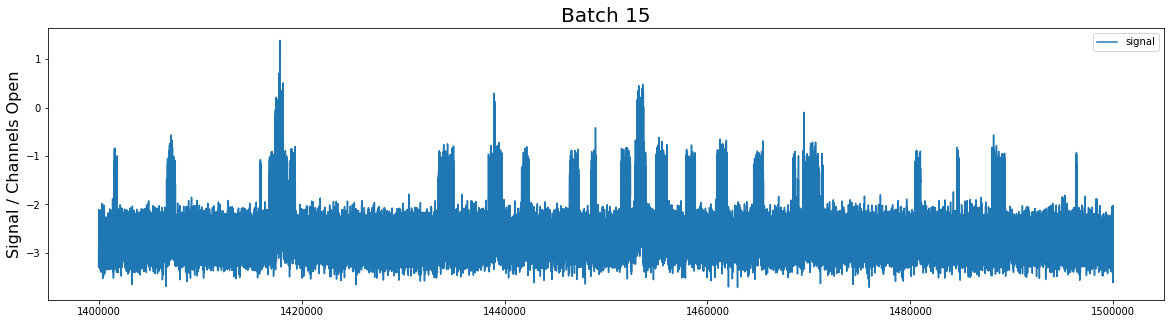

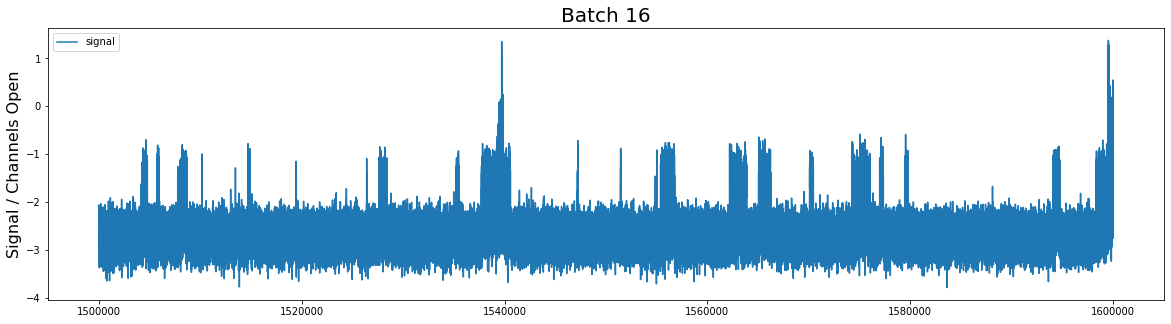

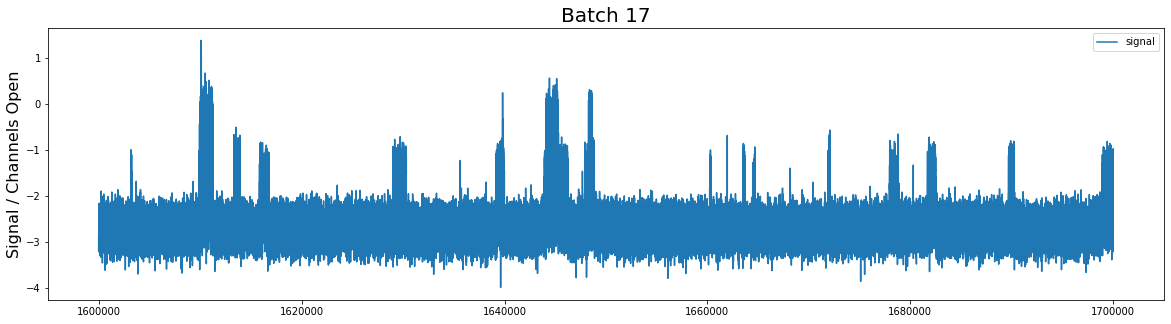

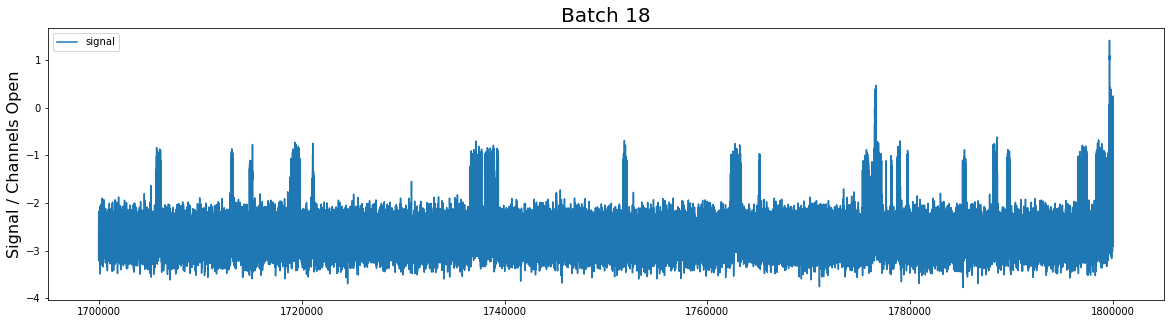

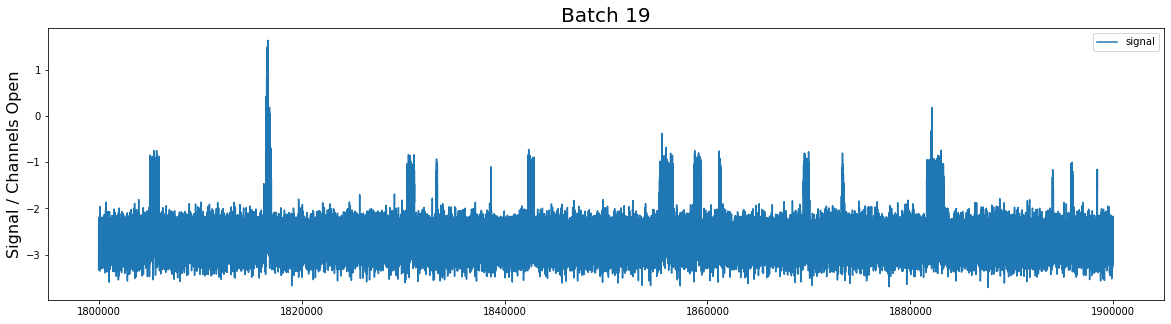

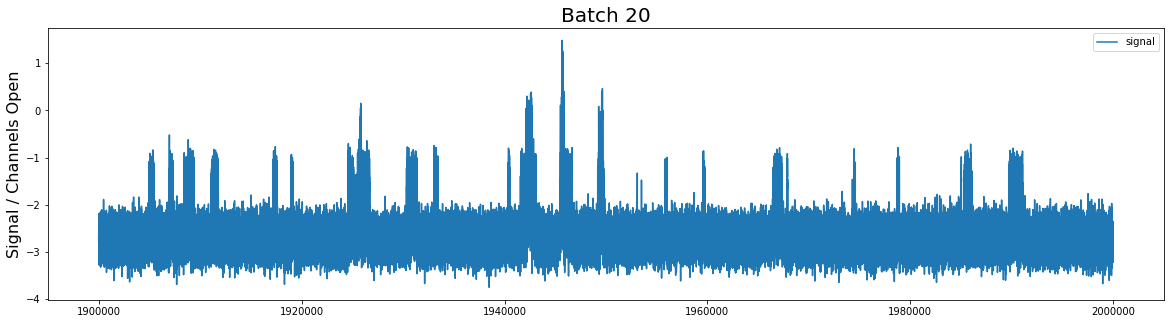

In [353]:
for i,(beg,end) in enumerate(zip(test_batches[0::],test_batches[1::])):
    show_subset(beg,end-1,step=1,df=test,title=f'Batch {i+1}')

Open Channels 0
mean: -2.728, std: 0.255, Q01: -3.31, Q99: -2.146

Open Channels 1
mean: -1.501, std: 0.313, Q01: -2.114, Q99: -0.891

Open Channels 2
mean: -0.28, std: 0.488, Q01: -1.091, Q99: 0.469

Open Channels 3
mean: 0.928, std: 0.502, Q01: -1.503, Q99: 1.674

Open Channels 4
mean: 1.995, std: 0.775, Q01: -0.985, Q99: 2.865

Open Channels 5
mean: 2.534, std: 1.324, Q01: -0.068, Q99: 4.063

Open Channels 6
mean: 1.941, std: 0.413, Q01: 0.978, Q99: 2.903

Open Channels 7
mean: 3.175, std: 0.412, Q01: 2.216, Q99: 4.132

Open Channels 8
mean: 4.409, std: 0.412, Q01: 3.451, Q99: 5.368

Open Channels 9
mean: 5.641, std: 0.411, Q01: 4.687, Q99: 6.599

Open Channels 10
mean: 6.875, std: 0.416, Q01: 5.917, Q99: 7.847



<ErrorbarContainer object of 3 artists>

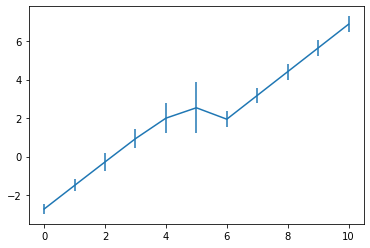

In [210]:
# Signal behavior per Channel
means,stds=[],[]
for i in range(0,11):
    c = train[train.open_channels==i]
    print(f"Open Channels {i}")
    g = c.signal
    means.append(g.mean())
    stds.append(g.std())
    f = lambda x: round(x,3)  # rounding function
    print(f"mean: {f(g.mean())}, std: {f(g.std())}, Q01: {f(g.quantile(.01))}, Q99: {f(g.quantile(.99))}\n")

plt.errorbar(range(0,11),means,stds)

## Test

In [135]:
step = 1000

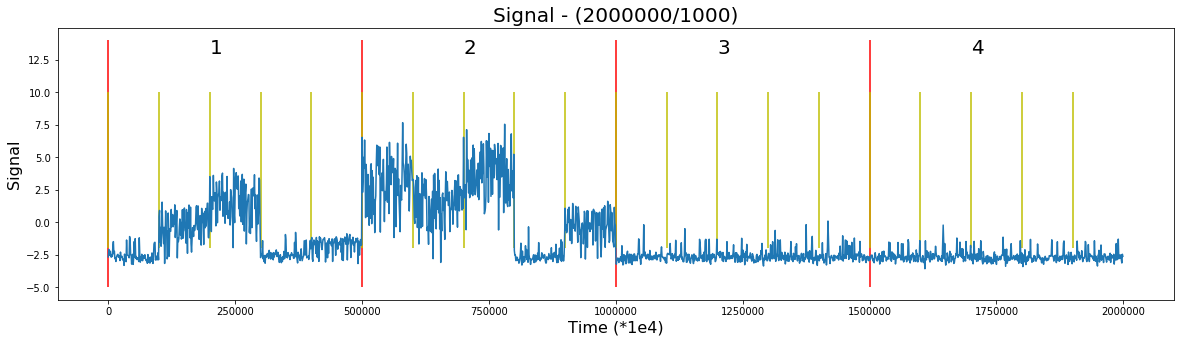

In [136]:
plt.figure(figsize=(20,5))
plt.plot(test.signal[0::step])

plt.vlines(range(0,len(test),500000),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
plt.vlines(range(0,len(test),100000),-2,10,'y')
for j in range(4): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Signal', size=16); 
plt.title(f'Signal - ({len(test)}/{step})',size=20)
plt.show()

## Investigate Training Outliers

In [262]:
# batch 4 - mean: -0.093, std: 1.003, Q01: -2.792, Q99: 1.478
# batch 8 - mean: -0.108, std: 1.17,  Q01: -3.133, Q99: 1.9

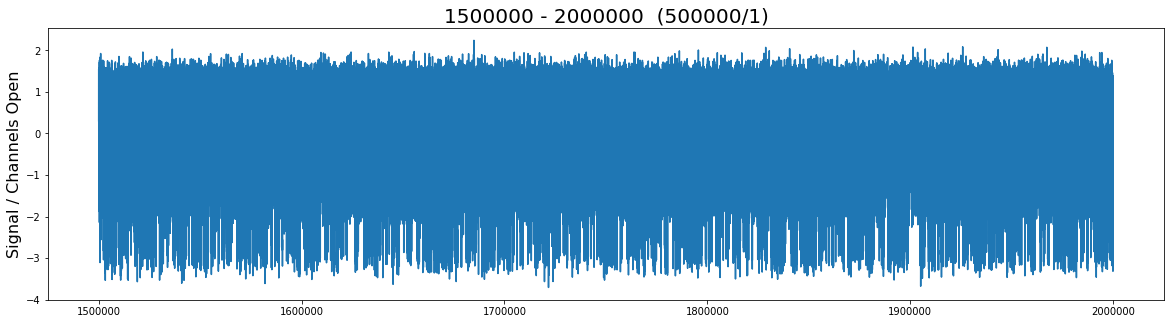

In [357]:
# group4
show_subset(int(1.5e6),int(2e6),step=1)#,add_fields=['open_channels'])

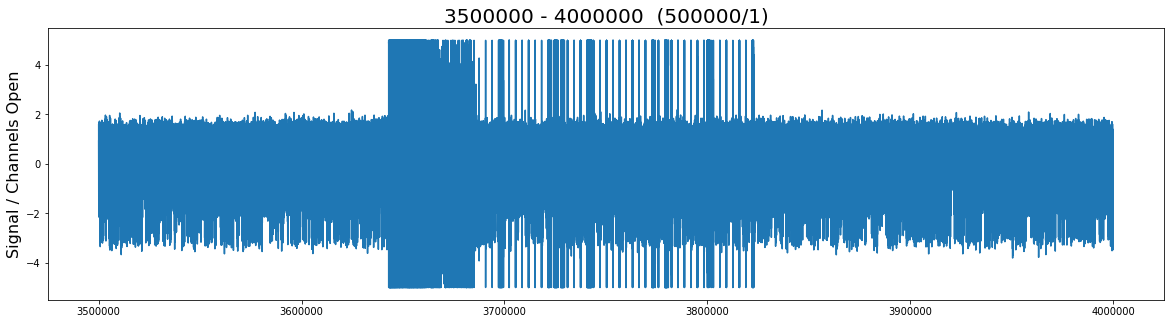

In [358]:
# group8
show_subset(int(3.5e6),int(4e6),step=1)

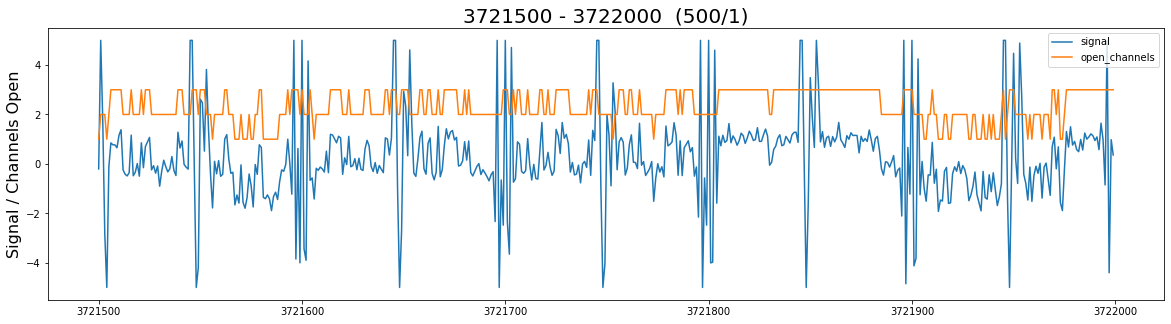

In [308]:
# group8 zoom in
show_subset(int(3.7215e6),int(3.722e6),step=1,add_fields=['open_channels'])

### Remove offending range

In [369]:
# ng8 = g8.drop(index=range(3642932,3822752))
ng8 = g8.drop(index=range(3642840,3822840))  # make it divisible by 4000 and 5000
# ng8.reset_index(inplace=True, drop=True)
ng8 = pd.concat((ng8,ng8[-180000:]), ignore_index=True)  # add another 1.8e6 to make even 5e6
len(ng8)

500000

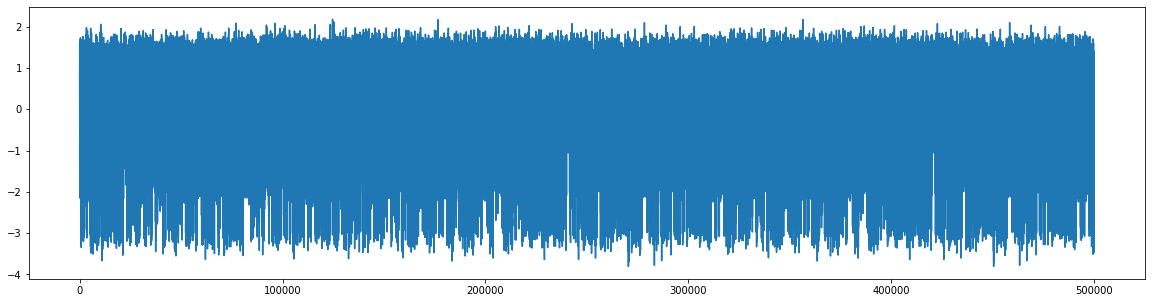

In [366]:
plt.figure(figsize=(20,5))
plt.plot(n.signal[::1])

# Separate into 3 models (fixed outliers)

In [409]:
gs = np.array_split(train,10)
ts = np.array_split(test, 20)

# clip outliers in group1
gs[0].signal.clip(None,0.6); None

# remove crazy signal from group8
gs[7].drop(index=range(3642840,3822840), inplace=True)  # make it divisible by 4000 and 5000
len(gs[7])

In [424]:
df1 = pd.concat([gs[0],gs[1],gs[2],gs[3],gs[6],gs[7]], ignore_index=True)  #0-3
df3 = pd.concat([gs[5],gs[8]], ignore_index=True)      #0-5
df2 = pd.concat([gs[4],gs[9]], ignore_index=True)      #0-10

tmp = pd.concat(ts[8:12], ignore_index=True)
tmp2 = pd.concat(ts[13:], ignore_index=True)
t1 = pd.concat([ts[0],ts[1],ts[3],ts[4],tmp,tmp2], ignore_index=True)
t2 = pd.concat([ts[2],ts[6],ts[12]], ignore_index=True)
t3 = pd.concat([ts[5],ts[7]], ignore_index=True)

# Separate into 5 models

In [ ]:
steps = list(range(0,5000001,500000))

for i,(beg,end) in enumerate(zip(steps[0::],steps[1::])):
    print(f"group {i+1}: {beg} - {end-1}")
    group = train[beg:end].signal
    print(f"mean: {round(group.mean(), 3)}, std: {round(group.std(), 3)}, \
Q01: {round(group.quantile(.01), 3)}, Q99: {round(group.quantile(.99),3)}\n")

In [ ]:
t_steps = list(range(0,2000001,100000))

for i,(beg,end) in enumerate(zip(t_steps[0::],t_steps[1::])):
    print(f"group {i+1} - {beg}:{end}")
    group = test[beg:end].signal
    print(f"mean: {round(group.mean(), 3)}, std: {round(group.std(), 3)}, \
Q01: {round(group.quantile(.01), 3)}, Q99: {round(group.quantile(.99),3)}\n")

In [69]:
df1 = train[0:1000000]
df2 = pd.concat([train[1000000:1500000],train[3000000:3500000]], ignore_index=True)
df3 = pd.concat([train[1500000:2000000],train[3500000:4000000]], ignore_index=True)
df4 = pd.concat([train[2000000:2500000],train[4500000:5000000]], ignore_index=True)
df5 = pd.concat([train[2500000:3000000],train[4000000:4500000]], ignore_index=True)

t1 = pd.concat([test[0:100000],test[300000:400000],test[800000:900000],test[1000000:]], ignore_index=True)
t2 = test[400000:500000]
t3 = pd.concat([test[100000:200000],test[900000:1000000]], ignore_index=True)
t4 = pd.concat([test[500000:600000],test[700000:800000]], ignore_index=True)
t5 = pd.concat([test[200000:300000],test[600000:700000]], ignore_index=True)

In [159]:
step=100

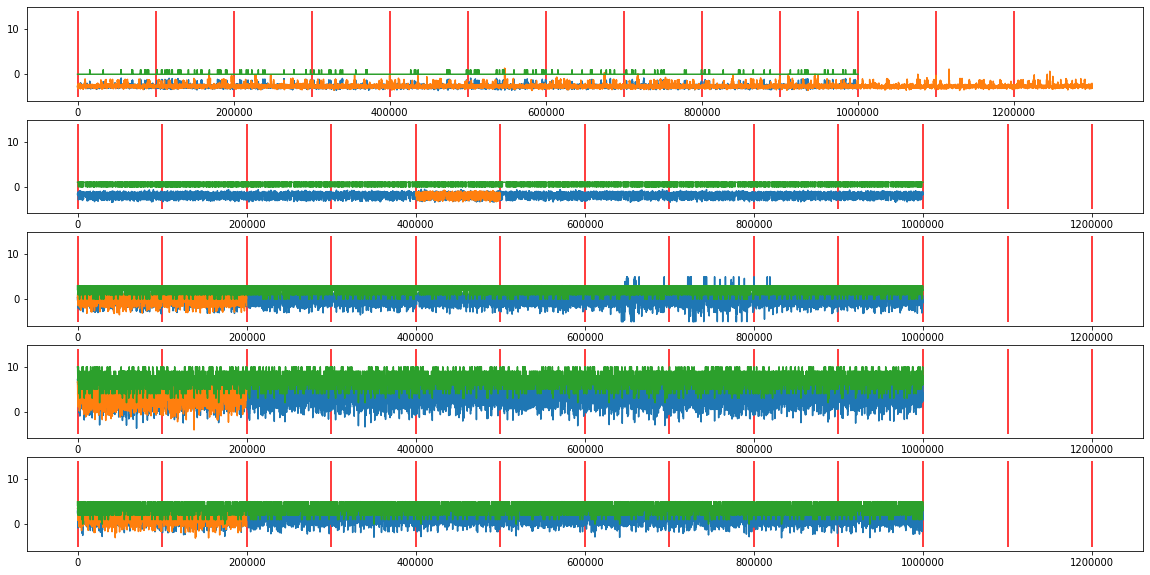

In [161]:
fig,axes = plt.subplots(5,1,figsize=(20,10))
for i,ax in enumerate(axes):
    df,t = eval('df'+str(i+1)), eval('t'+str(i+1))
# plt.figure(figsize=(20,5))
    ax.plot(df.signal[::step])
    ax.plot(t.signal[::step])
    ax.plot(df.open_channels[::step])

    ax.vlines(range(0,len(t1),100000),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
    
#     ax.xlabel('Time (*1e4)', size=16)
#     ax.ylabel('Signal', size=16); 
#     ax.title(f'Group {i+1}',size=20)
# plt.show()

In [163]:
for group in [df1.signal,t1.signal]:
    print(f"mean: {round(group.mean(), 3)}, std: {round(group.std(), 3)}, \
    Q01: {round(group.quantile(.001), 3)}, Q99: {round(group.quantile(.999),3)}\n")

mean: -2.682, std: 0.338,     Q01: -3.496, Q99: -1.009

mean: -2.603, std: 0.451,     Q01: -3.466, Q99: 0.029



## Analyzing group4

In [20]:
# import graphviz
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [21]:
def rf_feat_importance(m, feats):
    #return {f:i for f,i in zip(feats,m.feature_importances_)}
    return pd.DataFrame({'feats':feats, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [ ]:
# imbalanced dataset
for i in range(1,6):
    df = eval('df'+str(i))
    c = Counter(df.open_channels); c
    print('Group '+str(i))
    for i,n in c.most_common():
        print(f"{i}: {round(n/len(df4), 4)} ({n})")

### Graphs

In [ ]:
show_subset(500,1000,1,df4)

In [ ]:
res = 1000

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(df4.signal[0:len(t4):res])
plt.plot(df4.open_channels[0:len(t4):res])
plt.plot(t4.signal[0::res])

# plt.vlines(range(0,len(df4),500000),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
# for j in range(10): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Signal / Channels Open', size=16);
plt.title(f'Overlay - batches / {res}',size=20)
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(t4.signal[0::res])

#plt.vlines(range(0,len(t4),500000),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
plt.vlines(range(0,len(t4),100000),-2,10,'y')
#for j in range(4): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Signal', size=16); 
plt.title(f'Signal - ({len(test)}/{res})',size=20)
plt.show()

### DecisionTree

In [ ]:
# this is not as accurate as using seq_len datasets
# X = df4.signal.values.reshape(-1,1)
# Y = df4.open_channels.values.reshape(-1,1)

In [ ]:
seq_len = 1000
bs = 30

In [ ]:
# Single Feature
feats=['signal']

i = 4
X = eval('df'+str(i))['signal'].values.reshape(-1, seq_len, 1)
Y = eval('df'+str(i))['open_channels'].values.reshape(-1, seq_len)

tst_x = eval('t'+str(i))['signal'].values.reshape(-1, seq_len, 1)
tst_y = np.zeros_like(tst_x.squeeze())

In [ ]:
# DecisionTree
trn_idx,val_idx = trn_val_split(X.shape[0], 0.1)
trn_x, val_x = X[trn_idx], X[val_idx]
trn_y, val_y = Y[trn_idx], Y[val_idx]

trn_x,trn_y = trn_x.reshape(-1,1),trn_y.reshape(-1,1)
val_x,val_y = val_x.reshape(-1,1),val_y.reshape(-1,1)

In [ ]:
m = tree.DecisionTreeClassifier(min_samples_leaf=100)
m.fit(trn_x, trn_y)
print('Trained model 4 (10 channels)')
preds = m.predict(val_x)
print('F1 validation score: ', f1_score(val_y,preds,average='macro'))

In [ ]:
# !pip install graphviz
import graphviz

In [ ]:
s=tree.export_graphviz(m, out_file=None, feature_names=feats, filled=True, rounded=True, impurity=False, rotate=True,
                       special_characters=True, class_names=[str(i) for i in range(0,11)])
graphviz.Source(s)

### KFold RF

In [110]:
i = 3
trn_df = eval('df'+str(i))
tst_df = eval('t'+str(i))

X = trn_df[feats].values
Y = trn_df['open_channels'].values

tst_x = tst_df[feats].values
print(X.shape, Y.shape)

(1000000, 10) (1000000,)


In [111]:
kf = KFold(n_splits=10, shuffle=False)

In [112]:
res = []
scores = []

for i,(trn_idx,val_idx) in enumerate(kf.split(X, Y)):
    print(f"Starting {i+1} group")
    # split trn/val based on kfold idxs
    trn_x, val_x = X[trn_idx], X[val_idx]
    trn_y, val_y = Y[trn_idx], Y[val_idx]

    m = RandomForestClassifier(n_estimators=50, min_samples_leaf=1, n_jobs=-1)
    m.fit(trn_x, trn_y)
    preds = m.predict(val_x)
    score = f1_score(val_y,preds,average='macro')
    print('F1 validation score =', round(score,4))
    scores.append(score)

    # ensemble 
    res.append(m.predict(tst_x))
    
print(round(np.mean(scores),4))

Starting 1 group
F1 validation score = 0.9806
Starting 2 group
F1 validation score = 0.9829
Starting 3 group
F1 validation score = 0.9811
Starting 4 group
F1 validation score = 0.9828
Starting 5 group
F1 validation score = 0.9816
Starting 6 group
F1 validation score = 0.9694
Starting 7 group
F1 validation score = 0.8696
Starting 8 group
F1 validation score = 0.9499
Starting 9 group
F1 validation score = 0.9664
Starting 10 group
F1 validation score = 0.9787
0.9643


In [113]:
preds = np.median(np.stack(res), axis=0).astype(np.int)

### RandomForest

In [82]:
results = np.zeros(len(test), dtype=np.int)

In [ ]:
i = 5
trn_df = eval('df'+str(i)).copy()
tst_df = eval('t'+str(i)).copy()

X = np.array(list(trn_df.groupby('sequence').apply(lambda x: x[feats].values)))
Y = np.array(list(trn_df.groupby('sequence').apply(lambda x: x['open_channels'].values)))

tst_x = np.array(list(tst_df[feats].values))
print(X.shape, Y.shape)

In [ ]:
# RandomForest
# np.random.seed(42)

trn_idx,val_idx = trn_val_split(X.shape[0], 0.1)
trn_x, val_x = X[trn_idx], X[val_idx]
trn_y, val_y = Y[trn_idx], Y[val_idx]
print(val_y.shape)

trn_x,trn_y = trn_x.reshape(-1,len(feats)),trn_y.reshape(-1,)
val_x,val_y = val_x.reshape(-1,len(feats)),val_y.reshape(-1,)

In [ ]:
m = RandomForestClassifier(n_estimators=50, min_samples_leaf=1, n_jobs=-1)
m.fit(trn_x, trn_y)
preds = m.predict(val_x)
print('F1 validation score =', round(f1_score(val_y,preds,average='macro'),4))

# 0.9952  g1
# 0.9955  g2
# 0.9672  g3
# 0.8710  g4
# 0.9657  g5

In [ ]:
preds = m.predict(tst_x)

In [104]:
# group 1
results[0:100000] = preds[0:100000]
results[300000:400000] = preds[100000:200000]
results[800000:900000] = preds[200000:300000]
results[1000000:] = preds[300000:]

In [109]:
# group2
results[400000:500000] = preds

In [114]:
# group3
results[100000:200000] = preds[0:100000]
results[900000:1000000] = preds[100000:]

In [94]:
# group4
results[500000:600000] = preds[0:100000]
results[700000:800000] = preds[100000:]

In [99]:
# group5
results[200000:300000] = preds[0:100000]
results[600000:700000] = preds[100000:]

In [ ]:
# 0.8523  ['signal']
# 0.8523  ['signal', 'signal2']
# 0.8523  ['sig_exp', 'signal']
# 0.8523  ['signal', 'sig_exp', 'signal2']
# 0.8536  ['signal', 'ewma_2', 'ewma_3', 'ewma_4', 'ewma_5']
# 0.8569  ['signal', 'sig_exp', 'signal2', 'ewma_2', 'ewma_3', 'ewma_4', 'ewma_5']
# 0.8571  ['sig_exp', 'signal', 'signal2', 'ewma_2', 'ewma_3', 'ewma_5', 'ewma_4', 'diff_1', 'diff_2', 'diff_3']
# 0.8571  w/ shift
# 0.8616  (n_estimators=50, max_features='sqrt', min_samples_leaf=1, n_jobs=-1)
# 0.8592

# 0.8595  (n_estimators=100, max_features='sqrt', min_samples_leaf=1, n_jobs=-1)
# 0.8529  (n_estimators=20, max_features='sqrt', min_samples_leaf=1, n_jobs=-1)

# 0.8560  w/ rolling
# 0.8560  rolling instead of ewma
# 0.8562  w/ ewma 10 & 25
# 0.8563  w/ diff 4 & 5
# 0.8566  signal w/ ewmas & diffs

In [ ]:
rf_feat_importance(m,feats)

#### Train and Predict Test

In [ ]:
tst_x = tst_df[feats].values.reshape(-1,len(feats))

In [ ]:
m = RandomForestClassifier(n_estimators=20, min_samples_leaf=50, n_jobs=-1)
m.fit(X, Y)
preds = m.predict(tst_x)

In [ ]:
subm = pd.read_csv(PATH/"subm_v6.csv")

In [ ]:
g4 = pd.read_csv(PATH/"g4.csv"); g4.head()

In [ ]:
g42 = g4.copy()

In [ ]:
len(np.where(g4['0']!=g42['0'])[0])

In [ ]:
results = subm.open_channels.values

In [ ]:
preds = g4['0'].values

In [ ]:
results[500000:600000] = preds[0:100000]
results[700000:800000] = preds[100000:]

In [ ]:
rg4 = np.concatenate((results[500000:600000],results[700000:800000]))

In [ ]:
results.astype(np.int)

In [115]:
subm.open_channels = results.astype(np.int)

In [116]:
subm.to_csv(PATH/'subm_v10.csv', index=False, float_format='%.4f')

In [ ]:
df4.open_channels.values[150:200]

In [ ]:
# imbalanced dataset
c = Counter(subm.open_channels); c
#print(c.most_common())
for i,n in c.most_common():
    print(f"{i}: {round(n/len(subm), 4)} ({n})")

In [ ]:
# imbalanced dataset
c = Counter(results.astype(np.int)); c
#print(c.most_common())
for i,n in c.most_common():
    print(f"{i}: {round(n/len(results), 4)} ({n})")

# Single Feature Data

In [10]:
seq_len = 4000
bs = 30

In [11]:
X = train['signal'].values.reshape(-1, seq_len, 1)
Y = train['open_channels'].values.reshape(-1, seq_len)

tst_x = test['signal'].values.reshape(-1, seq_len, 1)
tst_y = np.zeros_like(tst_x.squeeze())

In [12]:
# normalize before split
mean,sigma = X.mean(),X.std()

X = (X-mean)/sigma
tst_x = (tst_x-mean)/sigma

print(X.mean(), X.std())
print(tst_x.mean(), tst_x.std())

1.064108801074326e-17 0.9999999999999998
-0.5534694036483198 0.9004955799436505


In [13]:
# val_idx based on test percentages of 5 groups
val_idx = np.array(
    list(range(0,163)) +       # 65% of group1
    list(range(250,262)) +     #  5% of group2
    list(range(500,525)) +     # 10% of group3
    list(range(750,775)) +     # 10% of group4
    list(range(1000,1025))     # 10% of group5
)

trn_idx = np.setdiff1d(range(len(X)),val_idx)
len(trn_idx)

trn_x, val_x = X[trn_idx], X[val_idx]
trn_y, val_y = Y[trn_idx], Y[val_idx]
print(trn_x.shape, val_x.shape)

(1000, 4000, 1) (250, 4000, 1)


In [102]:
# split trn/val
trn_idx,val_idx = trn_val_split(X.shape[0])

trn_x, val_x = X[trn_idx], X[val_idx]
trn_y, val_y = Y[trn_idx], Y[val_idx]
print(trn_x.shape, val_x.shape)

(1000, 4000, 1) (250, 4000, 1)


In [ ]:
kf = KFold(n_splits=5, shuffle=True)
# shuffle=False => sequential splits: [0..250],[250..500],[500..750],[750..1000],[1000..1250]
for i,(trn_idx,val_idx) in enumerate(kf.split(X, Y)):
    trn_x, val_x = X[trn_idx], X[val_idx]
    trn_y, val_y = Y[trn_idx], Y[val_idx]
    
    print(trn_x.shape, val_x.shape)

In [ ]:
# # normalize after split
# trn_mean = trn_x.mean()
# trn_sigma = trn_x.std()

# trn_x = (trn_x - trn_mean)/trn_sigma
# val_x = (val_x - trn_mean)/trn_sigma
# tst_x = (tst_x - trn_mean)/trn_sigma

# print(trn_x.mean(), trn_x.std())
# print(val_x.mean(), val_x.std())
# print(tst_x.mean(), tst_x.std())

### DataBunch

In [14]:
trn_ds = Ion_Dataset(trn_x, trn_y)
val_ds = Ion_Dataset(val_x, val_y)
tst_ds = Ion_Dataset(tst_x, tst_y)

trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False)
tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False)

data = DataBunch(trn_dl, val_dl, test_dl=tst_dl)

# Additional Features

In [10]:
seq_len = 5000
bs = 30

In [11]:
# np.clip is hacky way to get the std to near 1

def grouping_(df, seq, batch=100000):
    # group by batch
    df['batch'] = df.groupby(df.index//batch, sort=False)['signal'].agg(['ngroup']).values
    df['batch'] = df['batch'].astype(np.uint16)

    # group by seq_len
    df['sequence'] = df.groupby(df.index//seq, sort=False)['signal'].agg(['ngroup']).values
    df['sequence'] = df['sequence'].astype(np.uint16)

    # group_mean and percent change from group_mean
#     df['seq_mean'] = df.groupby('sequence')['signal'].transform('mean')
    #df['pct_seq_mean'] = np.clip((df['signal']/df['seq_mean'])-1,-2,2) #
    
#     df['bat_mean'] = df.groupby('batch')['signal'].transform('mean')
    #df['pct_bat_mean'] = np.clip((df['signal']/df['bat_mean'])-1,-2,2) #

def ewma_(df, windows):
    for w in windows:
        df['ewma_' + str(w)] = df.groupby('batch')['signal'].transform(lambda x: x.ewm(span=w).mean()).values
#         df['rolling_'+str(w)] = df.groupby('batch')['signal'].transform(lambda x: x.rolling(w).mean()).fillna(df['signal']).values

def shift_with_diff_(df, windows):
    # markovian process -> shift by 1 should be enough... but there appears to be delay in data sometimes
    for w in windows:
        df['shift_' + str(w)] = df.groupby('batch')['signal'].shift(w).fillna(df['signal'])
        #df['pct_change_' + str(w)] = np.clip((df['signal']/df['shift_' + str(w)])-1,-4,4) #
        df['diff_' + str(w)] = df['signal']-df['shift_' + str(w)]
        
        df.drop('shift_'+str(w), axis=1, inplace=True)
    
def square_signal_(df):
    df['signal2'] = df['signal']**2
    
def exp_signal_(df):
    df['sig_exp'] = np.exp(df.signal).values

In [12]:
for df in [train,test]:
    grouping_(df, seq_len)
    shift_with_diff_(df, [1,2,3])
    ewma_(df, [2,3,4,5])
    square_signal_(df)
    exp_signal_(df)

In [17]:
# check for no na values
np.all(~train.isnull().sum()) and np.all(~test.isnull().sum())

True

In [13]:
cols = train.columns.values
dels = np.array(['time', 'batch', 'sequence', 'open_channels'], dtype='object')
feats = list(np.setdiff1d(cols,dels))
print(feats)

['diff_1', 'diff_2', 'diff_3', 'ewma_2', 'ewma_3', 'ewma_4', 'ewma_5', 'sig_exp', 'signal', 'signal2']


In [ ]:
random_subsets(n=5, length=50000, step=1000, add_fields=['ewma_10', 'ewma_100', 'ewma_1000'])

In [ ]:
show_subset(3648500,3649000,1, add_fields=['ewma_5'])

In [ ]:
X = np.array(list(train.groupby('sequence').apply(lambda x: x[feats].values)))
Y = np.array(list(train.groupby('sequence').apply(lambda x: x['open_channels'].values)))

tst_x = np.array(list(test.groupby('sequence').apply(lambda x: x[feats].values)))
tst_y = np.zeros_like(tst_x.mean(-1))

In [15]:
print(X.shape, Y.shape)
print(tst_x.shape)

(1000, 5000, 10) (1000, 5000)
(400, 5000, 10)


### split trn/val

In [16]:
trn_idx,val_idx = trn_val_split(X.shape[0])

trn_x, val_x = X[trn_idx], X[val_idx]
trn_y, val_y = Y[trn_idx], Y[val_idx]
print(trn_x.shape, val_x.shape)

(800, 5000, 10) (200, 5000, 10)


In [ ]:
# normalize each feature individually after train/val split??

### Normalize

In [17]:
# set norms from trn_x
trn_means = trn_x.mean(axis=(0,1))
trn_stds = trn_x.std(axis=(0,1))

In [20]:
# normalize
trn_x = (trn_x - trn_means)/trn_stds
val_x = (val_x - trn_means)/trn_stds
tst_x = (tst_x - trn_means)/trn_stds

In [21]:
print(val_x.std(axis=(0,1)))
print(tst_x.std(axis=(0,1)))

[0.949077 0.948872 0.94967  0.966917 0.967246 0.967453 0.967598 0.942473 0.96622  0.941295]
[0.734435 0.730361 0.731183 0.900807 0.903654 0.905468 0.906781 0.696062 0.894826 0.71516 ]


### DataBunch

In [22]:
trn_ds = Ion_Dataset(trn_x, trn_y)
val_ds = Ion_Dataset(val_x, val_y)
tst_ds = Ion_Dataset(tst_x, tst_y)

trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False)
test_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False)

data = DataBunch(trn_dl, val_dl, test_dl=test_dl)

# Transformer

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [16]:
def rshift(tgt, bos_token=1):
    "Shift y to the right by prepending token"
    bos = torch.zeros((tgt.size(0),1), device=device).type_as(tgt) + bos_token
    return torch.cat((bos, tgt[:,:-1]), dim=-1)

def subsequent_mask(size):
    return torch.tril(torch.ones((1,size,size), device=device).byte())

In [17]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        
    def forward(self, pred, target):
        pred,targ = self.loss_prep(pred, target)
        pred = F.log_softmax(pred, dim=-1)        # necessary for KLDivLoss
        true_dist = pred.data.clone()
        true_dist.fill_(self.smoothing / pred.size(1))                  # fill with 0.0012
        true_dist.scatter_(1, targ.data.unsqueeze(1), self.confidence)  # [0.0012, 0.0012, 0.90, 0.0012]
        return F.kl_div(pred, true_dist, reduction='batchmean')
    
    def loss_prep(self, pred, target):
        "equalize input/target sl; combine bs/sl dimensions"
        bs,tsl = target.shape
        _ ,sl,vocab = pred.shape

        # F.pad( front,back for dimensions: 1,0,2 )
        if sl>tsl: target = F.pad(target, (0,sl-tsl))
        if tsl>sl: pred = F.pad(pred, (0,0,0,tsl-sl))

        targ = target.contiguous().view(-1).long()
        pred = pred.contiguous().view(-1, vocab)
        return pred, targ

In [18]:
class TeacherForce(LearnerCallback):
    def __init__(self, learn:Learner):
        super().__init__(learn)
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {'last_input':(last_input, last_target), 'last_target':last_target}

In [19]:
# LayerNorm = nn.LayerNorm
LayerNorm = partial(nn.LayerNorm, eps=1e-4)  # eps: 1e-4 accomodates mixed precision training

class SublayerConnection(nn.Module):
    "A residual connection followed by a layer norm.  Note: (for code simplicity) norm is first."
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([deepcopy(module) for _ in range(N)])

class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

class EncoderLayer(nn.Module):
    "Encoder: self-attn and feed forward"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)

    def forward(self, x, mask=None):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, src, tgt_mask=None):
        for layer in self.layers:
            x = layer(x, src, tgt_mask)
        return self.norm(x)

class DecoderLayer(nn.Module):
    "Decoder: self-attn, src-attn, and feed forward"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)  # wraps layer in residual,dropout,norm
 
    def forward(self, x, src, tgt_mask=None):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))  # acts as a weak LM
        x = self.sublayer[1](x, lambda x: self.src_attn(x, src, src))
        return self.sublayer[2](x, self.feed_forward)

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    depth = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(depth)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e4)  #changed from: -1e9 to accomodate mixed precision  
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, d_model, h=8, dropout=0.2):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h        # assume d_v always equals d_k
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        if mask is not None: mask = mask.unsqueeze(1)
        bs = q.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        q, k, v = [l(x).view(bs, -1, self.h, self.d_k).transpose(1,2) for l, x in zip(self.linears, (q, k, v))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(q, k, v, mask=mask, dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(bs, -1, self.h * self.d_k)
        return self.linears[-1](x)

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, dropout=0.2):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_model*4)
        self.w_2 = nn.Linear(d_model*4, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.w_2(self.dropout(F.gelu(self.w_1(x))))

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5001):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        log_increment = math.log(1e4) / d_model
        div_term = torch.exp(torch.arange(0.0, d_model, 2) * -log_increment)  
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe.unsqueeze_(0)

        self.register_buffer('pe', pe)    #(1,max_len,d_model)
        # registered buffers are Tensors (not Variables)
        # not a parameter but still want in the state_dict

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)    

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [20]:
class IonTransformer(Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
    
    def encode(self, src):
        return self.encoder(self.src_embed(src))
    
    def decode(self, src, tgt):
        bos_tok = 1 # ???
        tgt = rshift(tgt, bos_tok).long()
        mask = subsequent_mask(tgt.size(-1))
        return self.decoder(self.tgt_embed(tgt), src, mask)

    def generate(self, outs):
        return self.generator(outs)
    
    def forward(self, src, tgt=None, seq_len=4000):
        if tgt is not None:   #train
            outs = self.decode(self.encode(src), tgt)
            return self.generate(outs)
        else:                 #predict
            self.eval()
            with torch.no_grad():
                feats = self.encode(src)
                tgt = torch.ones((src.size(0),1), dtype=torch.long, device=device)

                res = []
                for i in progress_bar(range(seq_len)):
                    dec_outs = self.decode(feats, tgt)
                    prob = self.generate(dec_outs[:,-1])
                    res.append(prob)
                    pred = torch.argmax(prob, dim=-1, keepdim=True)
                    if (pred==0).all(): break
                    tgt = torch.cat([tgt,pred], dim=-1)
                return torch.stack(res).transpose(1,0).contiguous()

In [21]:
def make_full_model(vocab, d_model, N=4, drops=0, heads=8):
    c = deepcopy
    attn = MultiHeadedAttention(d_model, heads)
    ff = PositionwiseFeedForward(d_model, drops)
    pos = PositionalEncoding(d_model)
    
    model = IonTransformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), drops), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), drops), N),
        nn.Sequential(nn.Linear(1,d_model),c(pos)),
        nn.Sequential(Embeddings(d_model, vocab),c(pos)),
        nn.Linear(d_model, vocab),
    )
        
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
                    
    return model

In [27]:
np.log(.2)

-1.6094379124341003

In [22]:
def make_learner(data, d_model, N=4, drops=0.1, heads=8, smoothing=0.1):
    net = make_full_model(11, d_model, N, drops, heads)
    learn = Learner(data, net, loss_func=LabelSmoothing(smoothing), 
                    metrics=[f1], callback_fns=[TeacherForce])
    return learn

learn = make_learner(data, 32, N=1, drops=0.1, heads=4)

In [23]:
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,f1,time


KeyboardInterrupt: 

# WaveNet

In [ ]:
#convlution formula: output = input + 2*padding - kernel_size - (kernel_size-1)*(dilation-1)

def padding(i, o, d, k=3, s=1):
    return ((o-1)*s + (k-1)*(d-1) + k - i)/2

# k=3: padding = dilation    => maintain size
# k=2: padding = dilation//2 => maintain size
# k=1: padding = 0           => maintain size

In [ ]:
class Gated_Activation_Unit(Module):
    # w/ residual connection, batchnorm, and dropout
    def __init__(self, c, d, k=2, drop=0.2):
        self.d = d
        self.conv1 = nn.Conv1d(c, c, k, padding=self._pad(k,d), dilation=d) 
        self.tanh = nn.Tanh()
        self.conv2 = nn.Conv1d(c, c, k, padding=self._pad(k,d), dilation=d)
        self.sigm = nn.Sigmoid()
        self.conv_out = nn.Conv1d(c, c, 1)
        self.bn = nn.BatchNorm1d(c)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        res = x
        if self.d == 1: x = F.pad(x, (0,1))  # need asymmetric padding for dilation=1 scenario
        tanh = self.tanh(self.conv1(x))
        sigm = self.sigm(self.conv2(x))
        x = self.conv_out(tanh * sigm)
        x = self.bn(res + x)
        return self.drop(x)
       
    def _pad(self,k,d): return {3:d, 2:d//2, 1:0}[k]
    
    
class WaveBlock(Module):
    def __init__(self, in_c, out_c, dilations, drop):
        self.conv_in = nn.Conv1d(in_c, out_c, 1)
        self.layers = nn.Sequential(*[Gated_Activation_Unit(out_c,2**i,drop=drop) for i in range(dilations)])
    
    def forward(self, x): return self.layers(self.conv_in(x))
    
    
class CBR(Module):
    def __init__(self, in_c, out_c, k=3):
        self.layers = nn.Sequential(
            nn.Conv1d(in_c, out_c, k, padding=k//2),
            nn.BatchNorm1d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x): return self.layers(x)

In [ ]:
class WaveNet(Module):
    # without the skip connections
    def __init__(self, in_dim=1, out_dim=11, drop=0.2, channels=[16,32,64,128], dilations=[12,8,4,1]):
        channels = [in_dim]+channels

        self.blocks = nn.Sequential(*[WaveBlock(*args,drop) for args in zip(channels[0::1], channels[1::1], dilations)])
        # zip channels/dilations yielding: (c0,c1,d0), (c1,c2,d1), (c2,c3,d2), etc.
        self.out = nn.Linear(channels[-1], out_dim)
        self.drop = nn.Dropout(drop)
#         self.cbr1 = CBR(in_dim,64)
#         self.cbr2 = CBR(128,32)

    def forward(self, x):
        x = x.permute(0,2,1)
        #x = self.cbr1(x)
        x = self.blocks(x)
        #x = self.cbr2(x)
        x = self.drop(x)
        
        x = x.permute(0,2,1)
        return self.out(x)

In [ ]:
learn = Learner(data, WaveNet(len(feats),11), loss_func=loss_fn, metrics=[f1]) #, path=OUT_PATH)

In [ ]:
from fastai.callbacks import SaveModelCallback, ReduceLROnPlateauCallback

In [ ]:
learn.fit(1,1e-2, callbacks=[SaveModelCallback(learn, name='best'),
                             ReduceLROnPlateauCallback(learn, patience=5, factor=0.5, min_lr=1e-5)])

In [ ]:
subm = pd.read_csv(PATH/'subm_v2.csv')

In [ ]:
t = tensor(subm.open_channels.values); t.shape

In [ ]:
stack = torch.stack([t,t,t,t,t], dim=-1)

In [ ]:
stack.mode(dim=-1)

In [ ]:
len(np.where(subm.open_channels == subm1.open_channels)[0])

# Deep-Channel

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# scale dataset between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

dataset.min(), dataset.max(), dataset.mean(), dataset.std()

In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE - Synthetic Minority Over-sampling Technique -> resample all classes to equal the majority class
sm = SMOTE(sampling_strategy='auto', random_state=42)
X_res, Y_res = sm.fit_sample(x_train, y_train)

In [ ]:
class DeepChannel(Module):
    def __init__(self, feats, in_c=64, hid_c=256, out_c=11, num_layers=2):
        self.conv = nn.Conv1d(feats, in_c, 1, bias=False)
        self.bn = nn.BatchNorm1d(in_c)
        
        self.lstm1 = nn.LSTM(in_c, hid_c, batch_first=True, dropout=0.1)
        self.relu1 = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm1d(hid_c)
        
        self.lstm2 = nn.LSTM(hid_c, hid_c, batch_first=True, dropout=0.1)
        self.relu2 = nn.ReLU(inplace=True)
        self.bn2 = nn.BatchNorm1d(hid_c)

        self.lstm3 = nn.LSTM(hid_c, hid_c, batch_first=True, dropout=0.1)
        self.relu3 = nn.ReLU(inplace=True)
        self.bn3 = nn.BatchNorm1d(hid_c)

        self.lin = nn.Linear(hid_c, out_c)

    def forward(self, input):
        x = self.bn(F.relu(self.conv(input)))
        x,_ = self.bn1(F.relu(self.lstm1(x)))
        x,_ = self.bn2(F.relu(self.lstm2(x)))
        x,_ = self.bn3(F.relu(self.lstm3(x)))
        return self.lin(x)

In [ ]:
learn = Learner(db, model, loss_func=loss, metrics=[f1])

# 2 layer Bi-LSTM

In [ ]:
class Bi_RNN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, output_dim=11, num_layers=2):
        super(Bi_RNN, self).__init__()

        self.linear_in = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.linear_out = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, input):
        linear_input = self.linear_in(input)
        lstm_out, self.hidden = self.lstm(linear_input)
        return self.linear_out(lstm_out)

In [ ]:
learn = Learner(db, Bi_RNN(), loss_func=loss, metrics=[f1])

In [ ]:
# learn.clip_grad()

### Fit

In [ ]:
learn.fit(5, lr=1e-2)

# Seq Databunch

In [ ]:
class SeqProcessor():
    def __init__(self, ds:Collection=None, seq_len=5000):  self.seq_len = seq_len
    def process(self, ds:Collection):  ds.items = ds.items.reshape(-1, seq_len, 1)

In [ ]:
class SeqBatchSampler(torch.utils.data.Sampler):
    "split data up into n batches of seq_len"
    def __init__(self,data_source,seq_len):
        assert len(data_source)%seq_len==0
        self.seq_len = seq_len
        self.data_source = data_source.reshape(-1, seq_len, 1)

    def __len__(self): return len(self.data_source)
    def __iter__(self): return iter(self.data_source)

In [ ]:
d = ItemList.from_df(train, PATH, cols=1, processor=SeqProcessor)

In [ ]:
d.items

In [ ]:
def custom_collate(data):
    x,y = [],[]
    for ll in data:
        x.append(ll.x.items)
        y.append(ll.y.items)
    return (torch.Tensor(x), torch.LongTensor(y))

In [ ]:
class SeqDataBunch(DataBunch):
    @classmethod      # cls => databunch Class
    def create(cls, train_ds, valid_ds, test_ds=None, path='.',bs:int=30, seq_len:int=5000, **kwargs) -> DataBunch:
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        dataloaders = []
        for ds in datasets:
            samp = SeqBatchSampler(ds,seq_len=seq_len)
            dataloaders.append(DataLoader(ds, batch_size=bs, sampler=samp))
        return cls(*dataloaders, path=path, collate_fn=custom_collate)
    
    def normalize(self, mean=0., std=1.)->None:
        self.add_tfm(partial(self.norm_x, mean=mean, std=std))
        return self
    
    @staticmethod
    def norm_x(batch:Tuple[Tensor,Tensor], mean:float, std:float)->Tuple[Tensor,Tensor]:
        x,y = batch
        x = (x-mean)/std
        return x,y

In [ ]:
class SeqList(ItemList): 
    _processor = [SeqProcessor]
    #_bunch = SeqDataBunch

    def analyze_pred(self, pred:Tensor):
        return torch.argmax(pred, dim=-1)

In [ ]:
1000*.2

In [ ]:
np.arange(len(train)).reshape(-1,5000)

In [ ]:
np.random.randint(1000, size=200)

In [ ]:
idxs = np.arange(len(train)).reshape(-1,5000)[:,-int(0.2):].flatten()

In [ ]:
def valid_idxs(df,seq_len=5000,percent=0.2):
    full = np.arange(len(df)).reshape(-1,seq_len)
    rows = full.shape[0]
    num = int(rows*percent)
    idx = np.random.randint(rows, size=num)
    return full[idx].flatten()

In [ ]:
v_idxs = valid_idxs(train)

In [ ]:
v_idxs

In [ ]:
bs=100
bptt=100

v_idxs = valid_idxs(train, seq_len)

In [ ]:
data = (SeqList.from_df(train, PATH, cols=1)
        .split_by_idx(v_idxs)
        .label_from_df(cols=2, label_cls=SeqList)
        .databunch(bs=30)
       )

In [ ]:
d = data.databunch(bs=30)

In [ ]:
%debug

In [ ]:
data = data.normalize(mean=1.5597, std=3.4347)

# Mixed Sequential DataBunch

In [ ]:
# class NormProcessor(PreProcessor):
#     def __init__(self, ds:Collection=None):
#         self.means = ds.items.mean()
#         self.stds = ds.items.std()

#     def process_one(self, item:Any): return self.norm(item)
#     def process(self, ds:Collection): ds.items = self.norm(ds.items)
    
#     def norm(self, x): return (x - self.means)/(self.stds + 1e-7)

In [ ]:
class SeqBatchSampler(torch.utils.data.Sampler):
    "Return batches of indexes ~> [bs,bptt]"
    def __init__(self,data_source,bs=10,bptt=5000):
        self.length = len(data_source)
        assert self.length%bs==0
        self.bs,self.bptt = bs,bptt
        self.idxs = np.arange(self.length).reshape((bs,-1))

    def __len__(self): return self.length//self.bs
    
    def __iter__(self):
        self.cur_idx = 0
        return self
        
    def __next__(self):
        cur = self.cur_idx
        end = cur+self.bptt
        self.cur_idx = end
        res = self.idxs[:,cur:end]
        if res.shape[1] == 0: raise StopIteration
        return res

In [ ]:
def custom_collate(data):
    x,y = [],[]
    for ll in data:
        x.append(ll.x.items)
        y.append(ll.y.items)
    return (torch.Tensor(x), torch.LongTensor(y))

In [ ]:
class SeqDataBunch(DataBunch):
    @classmethod      # cls => databunch Class
    def create(cls, train_ds, valid_ds, test_ds=None, path='.', bs:int=10, bptt:int=5000, **kwargs) -> DataBunch:
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        dataloaders = []
        for ds in datasets:
            samp = SeqBatchSampler(ds,bs=bs,bptt=bptt)
            dataloaders.append(DataLoader(ds, batch_sampler=samp))
        return cls(*dataloaders, path=path, collate_fn=custom_collate)
    
    def normalize(self, mean=0., std=1.)->None:
        self.add_tfm(partial(self.norm_x, mean=mean, std=std))
        return self
    
    @staticmethod
    def norm_x(batch:Tuple[Tensor,Tensor], mean:float, std:float)->Tuple[Tensor,Tensor]:
        x,y = batch
        x = (x-mean)/std
        return x,y

In [ ]:
class SeqList(ItemList): 
    #_processor = [NormProcessor]
    _bunch = SeqDataBunch

    def analyze_pred(self, pred:Tensor):
        return torch.argmax(pred, dim=-1)

In [ ]:
def valid_idxs(df,bs=10,percent=0.2):
    length = len(df)
    pct = length/bs*percent
    assert pct.is_integer()
    return np.arange(length).reshape(bs,-1)[:,-int(pct):].flatten()

In [ ]:
bs=100
bptt=100

v_idxs = valid_idxs(train, bs=bs)

In [ ]:
data = (SeqList.from_df(train, PATH, cols=1)
        .split_by_idx(v_idxs)
        .label_from_df(cols=2)
        .databunch(bs=bs, bptt=bptt)
       )

In [ ]:
data = data.normalize(mean=1.5597, std=3.4347)

## Visualize (unnormalized) training batch

In [ ]:
x,y = next(iter(data.train_dl))

In [ ]:
step = 100
seq = bptt//step

plt.figure(figsize=(20,5))
plt.plot(x.numpy().flatten()[::step])
plt.plot(y.numpy().flatten()[::step])

plt.vlines(range(0,bs*seq,seq),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(bs): plt.text(j*seq+(seq/2),13,str(j+1),size=20)  # show batch numbers

plt.show()

## Visualize (normalized) training batch

In [ ]:
data = data.normalize(mean=1.5597, std=3.4347)

In [ ]:
x,y = next(iter(data.train_dl))

In [ ]:
step = 100
seq = bptt//step

plt.figure(figsize=(20,5))
plt.plot(x.numpy().flatten()[::step])
plt.plot(y.numpy().flatten()[::step])

plt.vlines(range(0,bs*seq,seq),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(bs): plt.text(j*seq+(seq/2),13,str(j+1),size=20)  # show batch numbers

plt.show()

# CNN + AWD_LSTM

In [ ]:
class ConvToLSTM(Module):
    def __init__(self, in_sz):
        self.conv = nn.Conv1d(1,in_sz,3,padding=1)
        
    def forward(self, input:Tensor):
        return self.conv(input.unsqueeze(1)).permute(0,2,1)

class mod_AWD_LSTM(Module):
    def __init__(self, in_sz:int, hid_sz:int, n_layers:int, hidden_p:float=0.2,
                 input_p:float=0.6, weight_p:float=0.5, bidir:bool=False):
        self.bs,self.in_sz,self.hid_sz,self.n_layers = 1,in_sz,hid_sz,n_layers
        self.n_dir = 2 if bidir else 1

        self.rnns = [nn.LSTM(self.in_sz if l == 0 else self.hid_sz, self.hid_sz//self.n_dir, 1,
                             batch_first=True, bidirectional=bidir) for l in range(n_layers)]
        self.rnns = [WeightDropout(rnn, weight_p) for rnn in self.rnns]
        self.rnns = nn.ModuleList(self.rnns)
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

    def forward(self, input:Tensor)->Tuple[Tensor,Tensor]:
        bs,sl,emb = input.size()
        if bs!=self.bs:
            self.bs=bs
            self.reset()
        raw_output = self.input_dp(input)
        new_hidden,raw_outputs,outputs = [],[],[]
        for l, (rnn,hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):
            raw_output, new_h = rnn(raw_output, self.hidden[l])
            new_hidden.append(new_h)
            raw_outputs.append(raw_output)
            if l != self.n_layers-1: raw_output = hid_dp(raw_output)
            outputs.append(raw_output)
        self.hidden = to_detach(new_hidden, cpu=False)
        return raw_outputs, outputs

    def _one_hidden(self, l:int)->Tensor:
        "Return one hidden state."
        nh = self.hid_sz // self.n_dir
        return one_param(self).new(self.n_dir, self.bs, nh).zero_()

    def reset(self):
        "Reset the hidden states."
        [r.reset() for r in self.rnns if hasattr(r, 'reset')]
        self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range(self.n_layers)]

def get_model(in_sz=32, hid_sz=64, out_sz=11, n_layers=3, out_p=0.4, **kwargs):
    return SequentialRNN(
        ConvToLSTM(in_sz),
        mod_AWD_LSTM(in_sz,hid_sz,n_layers,**kwargs),
        LinearDecoder(out_sz, hid_sz, output_p=out_p)
    )

In [ ]:
model = get_model()

In [ ]:
from sklearn.metrics import f1_score

def f1(preds, targs):
    return tensor(f1_score(targs.view(-1).detach().cpu(), preds.argmax(-1).view(-1).detach().cpu(), average='macro'))

In [ ]:
learn = LanguageLearner(data, model, metrics=[f1])

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
# learn.model.reset()

In [ ]:
learn.fit_one_cycle(1, 1e-1)

# Tabular Model

In [50]:
from fastai.tabular import *

In [74]:
df = train.drop(columns=['sequence'])

In [75]:
df.tail()

,time,signal,open_channels,batch,diff_1,diff_2,diff_3,ewma_2,ewma_3,ewma_4,ewma_5,signal2,sig_exp
4999995,499.9996,2.919274,7,49,-1.451869,-1.272037,0.571094,3.331420,3.461002,3.529061,3.584139,8.522163,18.527838
4999996,499.9997,2.697906,7,49,-0.221369,-1.673237,-1.493406,2.909077,3.079454,3.196599,3.288728,7.278695,14.848602
4999997,499.9998,4.516337,8,49,1.818431,1.597063,0.145194,3.980584,3.797896,3.724494,3.697931,20.397301,91.499835
4999998,499.9999,5.639669,9,49,1.123331,2.941763,2.720394,5.086640,4.718782,4.490564,4.345177,31.805862,281.369453
4999999,500.0000,5.379200,9,49,-0.260469,0.862863,2.681294,5.281680,5.048991,4.846018,4.689851,28.935793,216.848727


In [61]:
v_idx = (list(range(400_000,500_000)) +list(range( 900_000,1_000_000))+
        list(range(1400_000,1500_000))+list(range(1900_000,2_000_000))+
        list(range(2400_000,2500_000))+list(range(2900_000,3_000_000))+
        list(range(3400_000,3500_000))+list(range(3900_000,4_000_000))+
        list(range(4400_000,4500_000))+list(range(4900_000,5_000_000)))

In [76]:
tab_data = TabularDataBunch.from_df(PATH, train, 'open_channels',
                                    valid_idx=v_idx, procs=[Categorify, Normalize],
                                    cat_names=['batch'])

In [86]:
learn = tabular_learner(tab_data, layers=[256,256], metrics=[accuracy, f1], ps=0.2, emb_drop=0.2)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [87]:
learn.fit_one_cycle(1, 1e-2)

# 0 	0.123170	0.512317	0.824219	0.725570	15:52

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.123170,0.512317,0.824219,0.725570,15:52


# F1 evaluation

*positive class*: minority class(es)  
*negative class*: majority class

- Precision: number of true positive class predictions.  (minority class accuracy)
- Recall: number of positive class predictions made out of all positive examples in the dataset. (minority class coverage)
- F-Measure provides a single score that balances both the concerns of precision and recall in one number.

*precision* - TruePositives / (TruePositives + FalsePositives)  
*recall* - TruePositives / (TruePositives + FalseNegatives)

| *Binary*        | Positive Prediction | Negative Prediction |
| :-------------: | ------------------- | ------------------- |
|**Positive Class** | True Positive (TP) | False Negative (FN) |
|**Negative Class** | False Positive (FP) | True Negative (TN) |

In [ ]:
TP = (preds * y).sum(); TP

In [ ]:
prec = TP / preds.sum(); prec

In [ ]:
rec = TP / y.sum(); rec

In [ ]:
f1 = (prec*rec)/(prec+rec+1e-9)*2; f1

In [ ]:
TP = (y_pred*y_true).sum()
prec = TP/(y_pred.sum(dim=1)+eps)
rec = TP/(y_true.sum(dim=1)+eps)
res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)

In [ ]:
def evaluate(model,x,y):
    model.eval()
    with torch.no_grad():
        res = model(x)
        preds = res.argmax(dim=-1)
        f1
learn.model()